# Title: Emotion Recognition System

### Table of content
- Part A: EDA and Data Understanding
- Part B: Image Preprocessing
- Part C: Model Building
- Part D: Hyperparameter Tuning on our Best Model
- Part E: Final evaluation of our Best Model

**Insall necessary libraries**

In [1]:
#pip install tensorflow
#pip install opencv-python
#pip install scikit-image
#conda install keras

# Import Libraries

In [2]:
# Import basic libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import os
import random
import datetime
from collections import OrderedDict
from pathlib import Path
%matplotlib inline

# Import Sklearn libraries
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc, roc_auc_score, PrecisionRecallDisplay
from sklearn.preprocessing import LabelBinarizer

# Import Image augmentation libraries
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

# Import Deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D,GlobalMaxPooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Nadam, Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model

import numpy as np

# Part A: Exploratory Data Analysis and Data Understanding

### Load our dataset

 - After observing our image file which we have downloaded from kaggle, we observed 7 different classes for our Emotion dataset. Namely, angry, disgusted, fearful, happy, neutral, sad, surprised. We initialize a lists for our classes in the dataset. The indexing follows alphabetical order just like in our folder:
        0 - angry
        1 - disgusted
        2 - fearful
        3 - happy
        4 - neutral
        5 - sad 
        6 - surprised

In [3]:
# Initialize class labels
expressions = ['angry', 'disgusted', 'fearful', 'happy', 
        'neutral', 'sad', 'surprised']

**Function: load_dataset**

Below, we created a function to load our data by passing in the folder path of our dataset. The images will be stored as arrays using numpy.

In [4]:
# Load dataset function

# Some images may be in different size, we will standardize 
# our images to 48*48
pic_size = 48

def load_dataset(path):
    dataset = [] # Multidimensional array containing [image_array, class]
    for expr in expressions:
        full_path = os.path.join(path, expr)
        class_idx = expressions.index(expr) # Label encode the images using the expressions list we have created above
        for img in os.listdir(full_path):
            try:
                img_arr = cv2.imread(os.path.join(full_path, img))
                standardized_arr = cv2.resize(img_arr, (pic_size, pic_size))
                dataset.append([img_arr,class_idx])
            except Exception as e:
                print(e)
                
    return np.array(dataset)

**Explanation:** This function will accept an argument, which is path. To load the images, we should pass in the full path of where the image file is stored. This function will store the images as a 2D numpy array, first array is the image pixels, second array is the class label/expression of the image. The class label will be label encoded for now, but later on we will one hot encode it as the label is not an ordinal variable. The images are loaded in following the order of the classes, we will have to reshuffle them later to avoid bias during training, and help the model converge faster. The images are also standardized into
48x48 pixels.

**Load the data into train and test sets**

In [5]:
# specify the path to the dataset folder
path = "C:\\Users\\Acer\\Desktop\\ML Assignment\\"

# pass the arguments to the load_dataset function to get our data
train_set = load_dataset(path + 'train')
test_set = load_dataset(path + 'test')

C:\Users\Acer\AppData\Local\Temp/ipykernel_11792/4093793253.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(dataset)


**Identify the number of images we have in our datasets**

In [6]:
# Dimensions of our data
print('Dimension of train_set array: ' , train_set.shape)
print('Dimension of test_set array : ' , test_set.shape)

Dimension of train_set array:  (28709, 2)
Dimension of test_set array :  (7178, 2)


**Explanation:** From the output above, we can tell that we have 28709 train_set examples and 7178 test_set examples. The dataset is a two column matrix, first column contains the image pixels in array form, the second column is the class label of the image. Our dataset is a big dataset, since we are doing deep learning, it is better to have more data so that we can increase the model complexity without worrying about overfitting issues.

In [7]:
# Examine the first row of the matrix
train_set[0]

array([array([[[ 70,  70,  70],
               [ 80,  80,  80],
               [ 82,  82,  82],
               ...,
               [ 52,  52,  52],
               [ 43,  43,  43],
               [ 41,  41,  41]],

              [[ 65,  65,  65],
               [ 61,  61,  61],
               [ 58,  58,  58],
               ...,
               [ 56,  56,  56],
               [ 52,  52,  52],
               [ 44,  44,  44]],

              [[ 50,  50,  50],
               [ 43,  43,  43],
               [ 54,  54,  54],
               ...,
               [ 49,  49,  49],
               [ 56,  56,  56],
               [ 47,  47,  47]],

              ...,

              [[ 91,  91,  91],
               [ 65,  65,  65],
               [ 42,  42,  42],
               ...,
               [ 72,  72,  72],
               [ 56,  56,  56],
               [ 43,  43,  43]],

              [[ 77,  77,  77],
               [ 82,  82,  82],
               [ 79,  79,  79],
               ...,
        

In [8]:
# Examine the shape of a single image ___can change to plot pixel size
train_set[0][0].shape

(48, 48, 3)

**Explanation:** From the two outputs above, we understand that our image has resolution of 48x48 and our images have only one channel.

In [9]:
# Examine the class of the first image
train_set[0][1]

0

**Explanation:** The output above tells us the class of the first image. Index 0 means it is from the class 'angry'.

### Merging Train and Test set for  the time being

For now, it is not required to split our dataset into train and test set yet, since we are not training our model yet. Therefore we can concatenate both sets into one. This way it will be easier to examine our data.

In [10]:
# Row-wise concatenation should give us 28709 + 7178 = 35887 rows.
data = np.concatenate((train_set, test_set), axis = 0) 

In [11]:
data.shape

(35887, 2)

As expected, we get 35887 rows and the column remains the same as before. 

### Image visualization
Now we want to display our images using matplotlib to understand and examine our dataset

**Function: plot_images**

We create a function plot_images to automate the task of plotting the images. We only need to call the plot_images function below to display images in our datasets. To use the function below, we need to pass in the dataset and the expression.

In [12]:
# A function to display the first 6 images in the given class of the dataset
def plot_class_images(images, expr):
    count = 0
    print('The class [' + expressions[expr] + '] contains ' + str((images.shape)[0]) + ' Images.')
    print('Plotting the first 9 images : ')
    plt.figure(figsize = (7,7))
    for i in data:
        if i[1] == expr and count < 9:  
            count = count + 1
            plt.subplot(3,3,count)
            plt.imshow(i[0])
            plt.title(expressions[i[1]])
            plt.tight_layout()
    plt.show

### Displaying Images

**Angry, label = 0**

The class [angry] contains 35887 Images.
Plotting the first 9 images : 


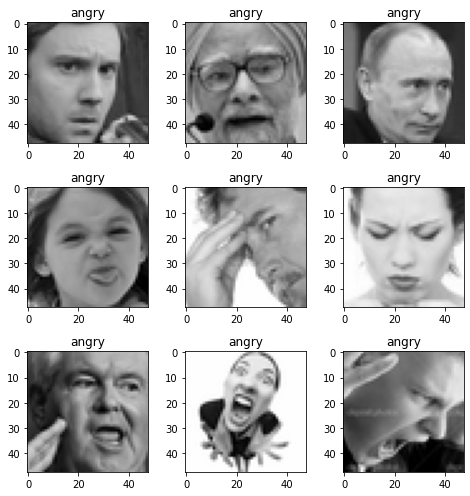

In [13]:
# Call the plot_image function to display images for class angry
plot_class_images(data, 0)

**Disgusted, label = 1**

The class [disgusted] contains 35887 Images.
Plotting the first 9 images : 


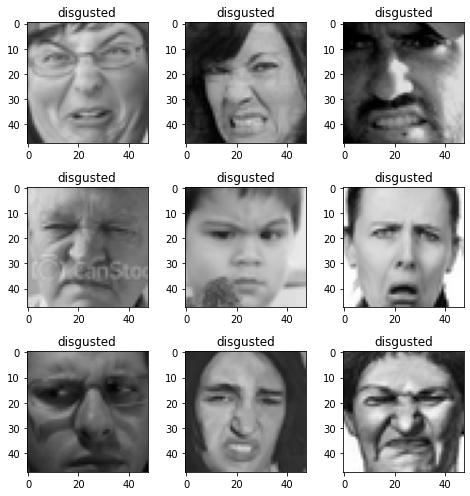

In [14]:
# Call the plot_image function to display images for class disgusted
plot_class_images(data, 1)

**Fearful, label = 2**

In [15]:
# Call the plot_image function to display images for class fearful
plot_class_images(data, 2)

The class [fearful] contains 35887 Images.
Plotting the first 9 images : 


Image 3 looks like an outlier!

**Happy, label = 3**

The class [happy] contains 35887 Images.
Plotting the first 9 images : 


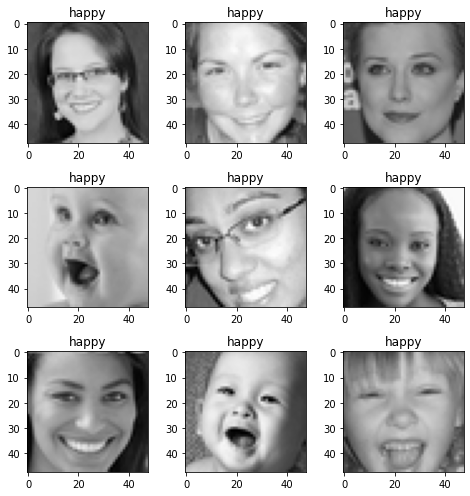

In [16]:
# Call the plot_image function to display images for class happy
plot_class_images(data, 3)

**Neutral, label = 4**

The class [neutral] contains 35887 Images.
Plotting the first 9 images : 


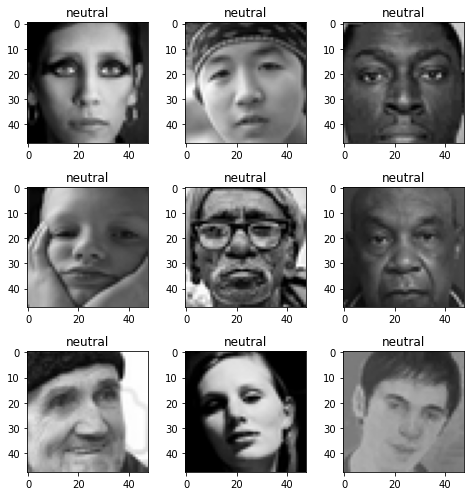

In [17]:
# Call the plot_image function to display images for class neutral
plot_class_images(data, 4)

**Sad, label = 5**

The class [sad] contains 35887 Images.
Plotting the first 9 images : 


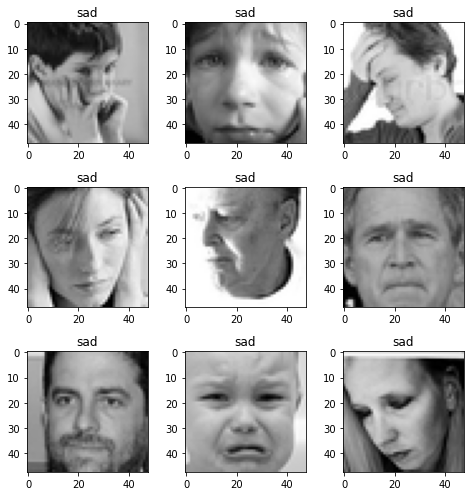

In [18]:
# Call the plot_image function to display images for class sad
plot_class_images(data, 5)

**Surprised, label = 6**

In [19]:
# Call the plot_image function to display images for class surprised
plot_class_images(data, 6)

The class [surprised] contains 35887 Images.
Plotting the first 9 images : 


**Interpretation:** The pictures for all the classes seems accurate enough except for one outlier in the class 'fearful'. Overall, the data is reliable and we can proceed with the project.

In [127]:
def plot_distribution(images):
    l = []
    for i in images:
        if(i[1] == 0):
            l.append("Angry")
        elif(i[1] == 1):
            l.append("Disgusted")
        elif(i[1] == 2):
            l.append("Fearful")
        elif(i[1] == 3):
            l.append("Happy")
        elif(i[1] == 4):
            l.append("Neutral")
        elif(i[1] == 5):
            l.append("Sad")
        elif(i[1] == 6):
            l.append("Surprised")
    sns.set(rc={'figure.figsize':(12,10)})
    sns.set_style('darkgrid')
    ax = sns.countplot(l)
    for p in ax.patches:
            ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.26, p.get_height()+60), fontsize = 15)
    ax.set_title("Frequency of Classes", fontsize = 20)
    ax.set_xlabel('Classes', fontsize = 20)
    ax.set_ylabel('Frequency', fontsize = 20)

In [128]:
plot_distribution(data)

D:\Anaconda\envs\GPUenabled\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


**Interpretation:** The countplot above shows that our dataset classes are not equally distributed(Imbalanced) as there are significantly less 'Disguested' images with only 547 examples. Other classes except 'Happy' are quite balanced with approximately 4002 to 6198 examples. Whereas the class 'Happy' have significantly more examples at 8989 examples.

# Part B: Image preprocessing

### Image Augmentation and Generating Train, Validation, and Test data.

In [4]:
# Specify the path of the train and test set
train_dir = os.path.join('train')
test_dir = os.path.join('test')

In [5]:
imheight, imwidth = 48, 48
batch_size = 64
num_class = 7
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30, fill_mode='nearest',
                                   width_shift_range=[0,5],
                                   height_shift_range=[0,5],
                                   validation_split = 0.2)

# We need a valid data generator so that we dont augment the validation set as well
valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2) 
test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (imheight, imwidth), 
                  color_mode = 'grayscale',
                  batch_size = batch_size,
                  class_mode = 'categorical', # multiclass
                  subset = 'training', # set as training data
                  seed = 125, # Seed is the same as in valid so that the validation set and train set are split without repetition
                  shuffle = True)

validation_set = valid_datagen.flow_from_directory(
                        train_dir,
                        target_size=(imheight, imwidth),
                        color_mode = 'grayscale',
                        batch_size=batch_size,
                        class_mode = 'categorical',
                        subset = 'validation',
                        seed = 125,
                        shuffle=False) # set as validation data 

test_set = test_datagen.flow_from_directory(
                    test_dir,
                    target_size =(imheight, imwidth),
                    color_mode = 'grayscale',
                    batch_size = batch_size,
                    class_mode ='categorical',
                    shuffle=False)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Check correctness of the label indices in the sets**

In [24]:
# Check labels indices in train_set to make sure they are standardized
train_labels = train_set.class_indices 
validation_labels = validation_set.class_indices
test_labels = test_set.class_indices
print("Train set labels indices:" , train_labels , "\n")
print("Validation set labels indices:" , validation_labels , "\n")
print("Test set labels indices:" , test_labels , "\n")

Train set labels indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6} 

Validation set labels indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6} 

Test set labels indices: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6} 



**Visualize the augmented images**

Display Augmented Images in Train set:

Label:  [0. 0. 0. 0. 1. 0. 0.]


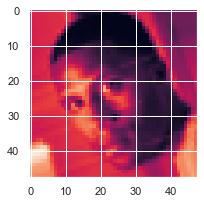

Label:  [0. 0. 0. 1. 0. 0. 0.]


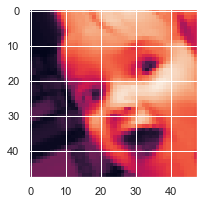

Label:  [0. 0. 0. 1. 0. 0. 0.]


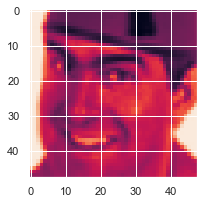

Label:  [0. 0. 0. 0. 0. 0. 1.]


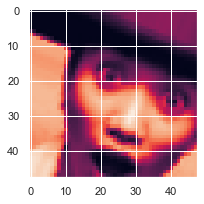

In [25]:
# Display the augmented images
print("Display Augmented Images in Train set:" + "\n")
for count in range(4):
    plt.figure(figsize=(3,3))
    img, label = train_set.next()
    print("Label: ", label[0])
    plt.imshow(img[0])
    plt.tight_layout()
    plt.show()

**Explanation:** Some images are rotated or shifted

**Define a function to plot the class distribution of the different sets.**

In [26]:
def sets_class_distribution():
    sets = [(train_set, 'Train set', 'green'),
            (validation_set, 'Validation set', 'brown'),
            (test_set, 'Test set', 'red')]
    
    for i, j , k in sets:
        class_train = i.classes
        classes = list(i.class_indices.keys())
        num_vals = []
        unique, counts = np.unique(class_train, return_counts = True)
        val_dict = OrderedDict(zip(unique, counts))
        for i in range(7):
            num_vals.append(val_dict[i])
        plt.figure(figsize=(10, 3))
        x = np.arange(len(num_vals))
        xlabel = classes
        plt.title('Number of Images per class in ' + j)
        plt.bar(x, num_vals, color=k)
        plt.xticks(x, xlabel)
        plt.show()
        print(num_vals)

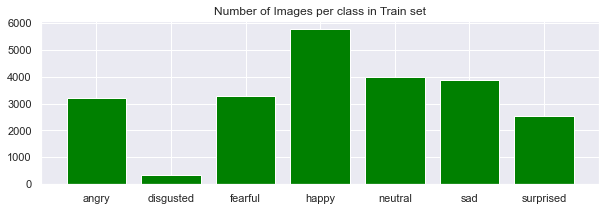

[3196, 349, 3278, 5772, 3972, 3864, 2537]


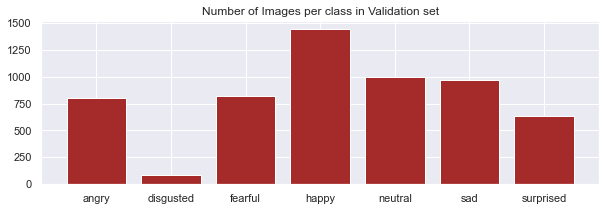

[799, 87, 819, 1443, 993, 966, 634]


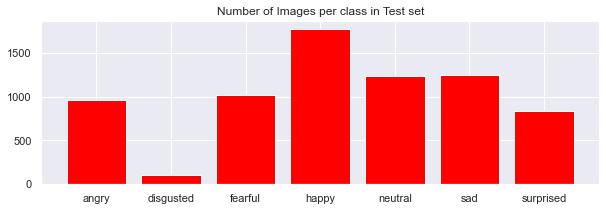

[958, 111, 1024, 1774, 1233, 1247, 831]


In [27]:
sets_class_distribution()

**Explanation:** The distribution we are most interested in is the one in train set. From the train set distribution, we infer that the classes are heavly imbalanced especially in disgusted class and happy class, this will affect the model's F1-score, to counter this issue, we will do weight adjusting for the model so that the model equally penalize under or over represented classes in the set.

**Adjusting class weights**

In [28]:
# Setting class weights to handle imbalanceness of our dataset
import sklearn
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                    classes = np.unique(train_set.classes),
                                    y = train_set.classes)
class_weights = dict(zip(np.unique(train_set.classes), class_weights))
class_weights      

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

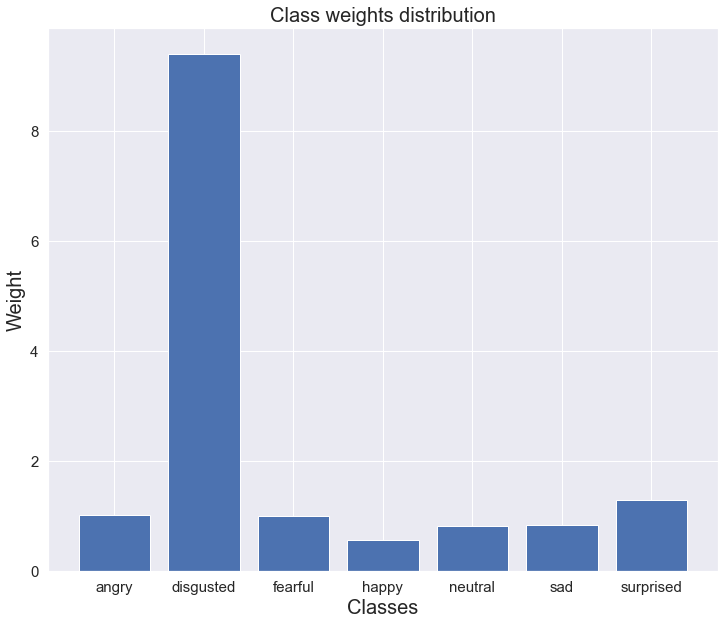

In [122]:
weights_keys = expressions
weights_values = list(class_weights.values())

plt.bar(range(len(class_weights)), weights_values, tick_label=weights_keys)
plt.title("Class weights distribution", fontsize = 20)
plt.xlabel('Classes', fontsize = 20)
plt.xticks(fontsize = 15)
plt.ylabel('Weight', fontsize = 20)
plt.yticks(fontsize = 15)
plt.show()

**Explanation:** Now we have the class weights parameter to pass into our CNN model, so now it will perform a bit better on predicting the 'disgusted' class and won't overfit on the 'happy' class.

# Part C: Model Building

This is the most important phase in Deep Learning, we will be building 7 models on our dataset. 1 custom built CNN and 6 pre-trained model using Transfer Learning. The models are:
1. Custom CNN
2. VGG16
3. ResNet50V2
4. MobileNetV2
5. DenseNet169

**Check whether our python environment is running on GPU or not**

In [30]:
# Identify number of GPU available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


**Explanation:** If the available GPU displays 1, it means our python environment found a GPU on our system. To run python on GPU, we need to install CUDA, and CuDNN, and create a new environment.

In [31]:
# Displays the devices that are found by tensorflow
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6287142050489154786
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2922866279
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17281263532584205583
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


 **Explanation:** The model of our GPU will be displayed above, I am running on NVDIA GeForce GTX 1050. Running on GPU makes the training od the model around 7 times faster. It is important because our dataset is very large, and the CNN model we will be running is very complex. To save time, running on GPU is ideal.

**Here, we will define all the callbacks for the model training**

In [32]:
# Defining checkpoints, early stopping, reduce learning rate and callback list
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def define_callbacks(checkpoint):
    early_stopping = EarlyStopping(monitor='val_accuracy',
                        min_delta=0,
                        patience=7,
                        verbose=1,
                        restore_best_weights=True
                        )

    reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                           factor = 0.2,
                                           patience=3,
                                           verbose=1,
                                           min_delta=0.0001)

    callbacks = [early_stopping, checkpoint, reduce_learningrate]
    
    return callbacks

**Explanation:** Above, we defined three important arguments for our callback:
1. checkpoint - Saves the best model into a h5 file based on the validation accuracy.
2. early_stopping - This stops the training of the model when validation accuacy hits a plateau, and it will restore the best weights during the training.
3. reduce_learningrate - This callback argument will monitor the validation loss and adjust the learning rate based on it, the adjustment will be on a factor of 0.2.

The reason checkpoint needs to be passed as an argument is because each model needs to be saved in a different h5 file, whereas early_stopping and reduce_learningrate is the same for all the model.

**Define a function to automatically train our models**

In [165]:
def train_model(model, train_set, validation_set, test_set, callbacks, class_weights=None, epochs=40):
    
    # Declaring the hyperparameters and compiling the model
    
    # Hyperparameters for Part C:
    batch_size = 64 
    opt = Adam(0.01) 
    #epoch = 60
    
    # Hyperparameters for Part D:
    
    # Batch Size : 32, 128
    #batch_size = 32  
    
    # Optimizers: [Adam, Nadam, SGD, SGD with Nesterov, RMSprop], Learning rate = 0.001
    #opt = Adam(0.001) #-> Test Accuracy : 63%
    #opt = SGD(0.001)  #-> Test Accuracy : 23%
    #opt = SGD(learning_rate = 0.001, momentum = 0.9, nesterov=True)  #-> Test Accuracy : 36%
    #opt = Nadam(0.001) # Best --> Test Accuracy : 65%
    #opt = RMSprop(0.001)
    
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
              tf.keras.metrics.AUC()]
    model.compile(optimizer = opt,
              loss = loss,
              metrics=metrics)
    
    # Start the training of the model
    start_time = datetime.datetime.now()
    history = model.fit(train_set,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_data = validation_set,
                        callbacks = callbacks,
                        class_weight = class_weights)
    print("Time taken to train: %s\n"% (datetime.datetime.now()-start_time))
    
    # Display model performance metrics
    train_performance = model.evaluate(train_set, verbose=0)
    validation_performance = model.evaluate(validation_set, verbose=0)
    test_performance = model.evaluate(test_set, verbose=0)
    scores = [('Training scores: ', train_performance),('Validation scores: ', validation_performance),('Test scores: ', test_performance)]
    
    for i, j in scores:
        print(i)
        print('=============================')
        print("Loss: ", round(j[0], 4))
        print("Accuracy: ", round(j[1], 4))
        print("Precision: ", round(j[2], 4))
        print("Recall: ", round(j[3], 4))
        print("AUC: ", round(j[4], 4))
        
        print('=============================' + '\n')
        
    return history

**Explanation:** For our Model Building phase, we will use the same hyperparameters for all the models 
1. Optimization Algorithm: Adam (Adaptive Moment Estimation)
2. Loss function         : categorical_crossentropy
3. Metrics               : accuracy
4. Learning Rate         : 0.01
5. Epochs                : 40  as default
6. Batch size            : 64

Only after shortlisting the best models for our dataset, will we start doing hyperparameter tuning.

**Define a function to automatically generate plots and visualize the performance of our models**

In [34]:
def plot_model_performance(model, history, test_set, name):
    
    # Define number of subplots and size
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)

    # Plot Accuracy of model on train vs validation set
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title(name + ': Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].legend(['Train', 'Validation'], loc='best')

    # Plot Loss of model on train vs validation set
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title(name + ': Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(['Train', 'Validation'], loc='best')
    
    # Plot AUC of model on test set
    roc_auc_plot(model, test_set, name)
    
    # Plot error on each classes, confusion matrix, and classification report using print_info() function
    print_code=0
    length = len(test_set)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    preds=model.predict(test_set, steps=test_steps, verbose=1) 
    print_info(test_set, preds, print_code, name)  # print_info is the function which prints classfication re
    
    plt.show()

In [35]:
def roc_auc_plot(model, test_set, name, average="macro"):
    fig, c_ax = plt.subplots(1,1, figsize = (10,10))
    y_test = np.array(test_set.classes)
    y_pred = model.predict(test_set)
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(expressions):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    score = roc_auc_score(y_test, y_pred, average=average)
    plt.title(name + ': ROC AUC score: {:.4f}'.format(score))
    plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
    plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
    plt.legend(fontsize = 11.5)
    plt.show()

In [36]:
def print_info( test_gen, preds, print_code, name, subject='expression' ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    
    # Plot Error on each classes
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title(name + ':  Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    
    # Plot Confusion Matrix
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred)        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='PuBu', cbar=True)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(name + ": Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print(name + ": Classification Report on Test Set:\n----------------------\n", clr)

**Explanation:** We have defined a function to automate the visualization of our models' performance. The plots that will be generated in this function are:
1. Accuracy on Training vs Validation set
2. Loss on Training vs Validation set
3. ROC AUC on Test set
4. Confusion Matrix on Test set
5. Classification Report on Test set

**Define a function to automatically predict a few images in the test set using our newly trained model**

In [9]:
def classify_test(model, expression, channel=1):
    path = "C:\\Users\\Acer\\Desktop\\ML Assignment\\"
    path_test = Path(os.path.join(path, "test\\", expression, "im0.png"))
    dic = test_set.class_indices
    idc = {k:v for v, k in dic.items()}
    
    if channel == 1:
        target_size = (48,48,1)
        grayscale=True
    elif channel == 3:
        target_size = (48,48,3)
        grayscale=False
    
    image = load_img(path_test,grayscale=grayscale, target_size=(target_size))
    image = img_to_array(image)
    image = image/255
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.axis('off')
    image = np.expand_dims(image, axis=0)
    prediction = model(image)
    i = np.argmax(prediction)
    classification = idc[i]
    
    print("Predicted Class: ", classification)
    print("Probability: ", prediction)

**Explanation:** This function is created to test a trained model to classify one images by passing in the class of the image we want to test.

## Training the models

### Model 1: Custom built CNN

**Specifying the CNN architecture**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                        

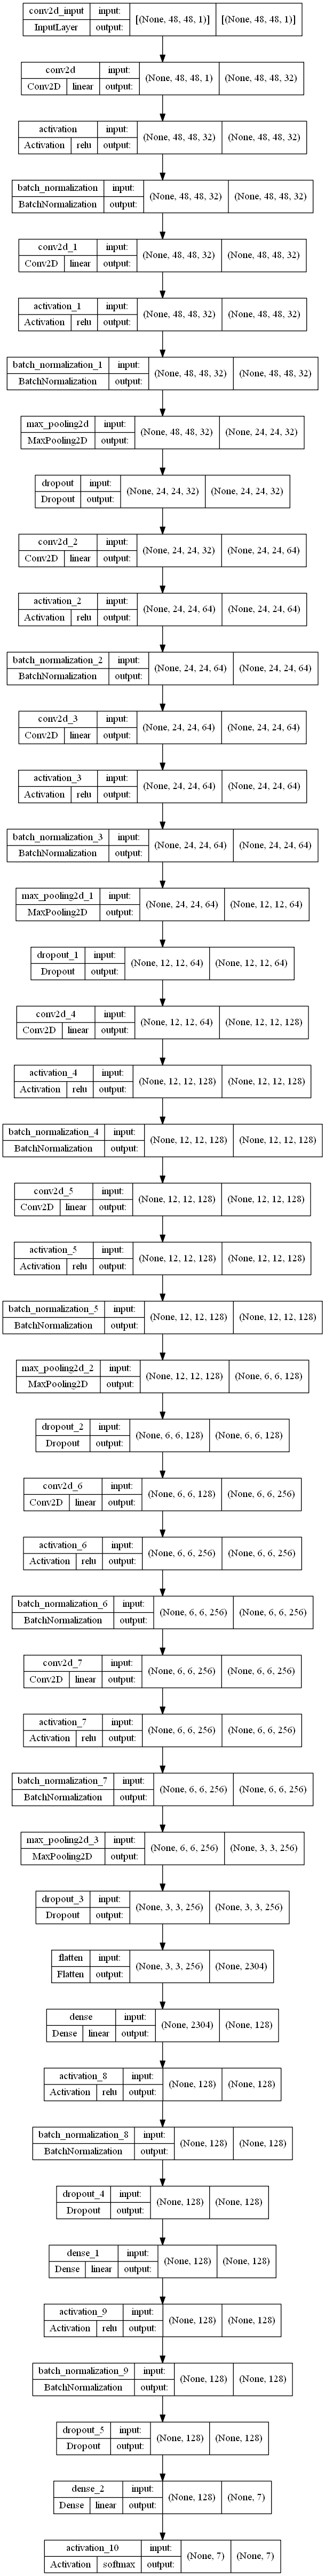

In [38]:
# Specifying the model architecture

CNN = Sequential()

# Feature Learning layers
# Block-1
CNN.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
CNN.add(Activation('relu'))
CNN.add(BatchNormalization())
CNN.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
CNN.add(Activation('relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2,2)))
CNN.add(Dropout(0.2))

# Block-2 

CNN.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
CNN.add(Activation('relu'))
CNN.add(BatchNormalization())
CNN.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
CNN.add(Activation('relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2,2)))
CNN.add(Dropout(0.2))

# Block-3

CNN.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
CNN.add(Activation('relu'))
CNN.add(BatchNormalization())
CNN.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
CNN.add(Activation('relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2,2)))
CNN.add(Dropout(0.2))

# Block-4 

CNN.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
CNN.add(Activation('relu'))
CNN.add(BatchNormalization())
CNN.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
CNN.add(Activation('relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2,2)))
CNN.add(Dropout(0.2))

# Classification Layers
# Block-1

CNN.add(Flatten())
CNN.add(Dense(128,kernel_initializer='he_normal'))
CNN.add(Activation('relu'))
CNN.add(BatchNormalization())
CNN.add(Dropout(0.2))

# Block-2

CNN.add(Dense(128,kernel_initializer='he_normal'))
CNN.add(Activation('relu'))
CNN.add(BatchNormalization())
CNN.add(Dropout(0.2))

# Block-3

CNN.add(Dense(7,kernel_initializer='he_normal'))
CNN.add(Activation('softmax')) # Softmax activation since we are doing multiclass classification

# Display summary of architecture
CNN.summary()
plot_model(CNN, 'CNN.png', show_shapes = True, show_layer_activations = True)

**Explanation:** Details and reasoning about the architecture can be found in our report

**Fitting the Model with Training and Validation Data**

In [147]:
# Training the model

CNN_checkpoint = ModelCheckpoint("./CNN.h5", monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')
CNN_callbacks = define_callbacks(CNN_checkpoint)

CNN_history = train_model(CNN, train_set, validation_set, test_set, CNN_callbacks, class_weights, epochs=60)

Epoch 1/60
359/359 [==============================] - ETA: 0s - loss: 2.2066 - accuracy: 0.1708 - precision_9: 0.1820 - recall_9: 0.0262 - auc_9: 0.5423
Epoch 1: val_accuracy improved from -inf to 0.20571, saving model to .\CNN.h5
359/359 [==============================] - 60s 148ms/step - loss: 2.2066 - accuracy: 0.1708 - precision_9: 0.1820 - recall_9: 0.0262 - auc_9: 0.5423 - val_loss: 2.1502 - val_accuracy: 0.2057 - val_precision_9: 0.2043 - val_recall_9: 0.0688 - val_auc_9: 0.6263 - lr: 0.0010
Epoch 2/60
359/359 [==============================] - ETA: 0s - loss: 1.9621 - accuracy: 0.1927 - precision_9: 0.3322 - recall_9: 0.0206 - auc_9: 0.5888
Epoch 2: val_accuracy improved from 0.20571 to 0.23184, saving model to .\CNN.h5
359/359 [==============================] - 30s 84ms/step - loss: 1.9621 - accuracy: 0.1927 - precision_9: 0.3322 - recall_9: 0.0206 - auc_9: 0.5888 - val_loss: 1.8665 - val_accuracy: 0.2318 - val_precision_9: 0.5111 - val_recall_9: 0.0442 - val_auc_9: 0.6350 - l

359/359 [==============================] - 50s 139ms/step - loss: 1.2167 - accuracy: 0.5338 - precision_9: 0.7160 - recall_9: 0.3445 - auc_9: 0.8694 - val_loss: 1.1062 - val_accuracy: 0.5828 - val_precision_9: 0.7371 - val_recall_9: 0.3999 - val_auc_9: 0.8967 - lr: 0.0010
Epoch 18/60
359/359 [==============================] - ETA: 0s - loss: 1.1976 - accuracy: 0.5417 - precision_9: 0.7173 - recall_9: 0.3491 - auc_9: 0.8730
Epoch 18: val_accuracy did not improve from 0.58370
359/359 [==============================] - 57s 157ms/step - loss: 1.1976 - accuracy: 0.5417 - precision_9: 0.7173 - recall_9: 0.3491 - auc_9: 0.8730 - val_loss: 1.1591 - val_accuracy: 0.5591 - val_precision_9: 0.7036 - val_recall_9: 0.4123 - val_auc_9: 0.8869 - lr: 0.0010
Epoch 19/60
359/359 [==============================] - ETA: 0s - loss: 1.1947 - accuracy: 0.5417 - precision_9: 0.7215 - recall_9: 0.3526 - auc_9: 0.8747
Epoch 19: val_accuracy did not improve from 0.58370
359/359 [==============================] -

Epoch 34/60
359/359 [==============================] - ETA: 0s - loss: 1.0230 - accuracy: 0.5963 - precision_9: 0.7491 - recall_9: 0.4350 - auc_9: 0.9031
Epoch 34: val_accuracy improved from 0.61766 to 0.61975, saving model to .\CNN.h5
359/359 [==============================] - 59s 163ms/step - loss: 1.0230 - accuracy: 0.5963 - precision_9: 0.7491 - recall_9: 0.4350 - auc_9: 0.9031 - val_loss: 1.0237 - val_accuracy: 0.6198 - val_precision_9: 0.7405 - val_recall_9: 0.4762 - val_auc_9: 0.9122 - lr: 2.0000e-04
Epoch 35/60
359/359 [==============================] - ETA: 0s - loss: 1.0207 - accuracy: 0.5928 - precision_9: 0.7422 - recall_9: 0.4338 - auc_9: 0.9032
Epoch 35: val_accuracy did not improve from 0.61975
359/359 [==============================] - 57s 158ms/step - loss: 1.0207 - accuracy: 0.5928 - precision_9: 0.7422 - recall_9: 0.4338 - auc_9: 0.9032 - val_loss: 1.0325 - val_accuracy: 0.6175 - val_precision_9: 0.7414 - val_recall_9: 0.4719 - val_auc_9: 0.9110 - lr: 2.0000e-04
Epoc

**Explanation:** The model was able to train for 46 epochs, which is not bad. The accuracy on test set is a little bit low, but this is due to the nature of the dataset.

In [148]:
# Load the trained and saved model
CNN_model = keras.models.load_model('CNN.h5')

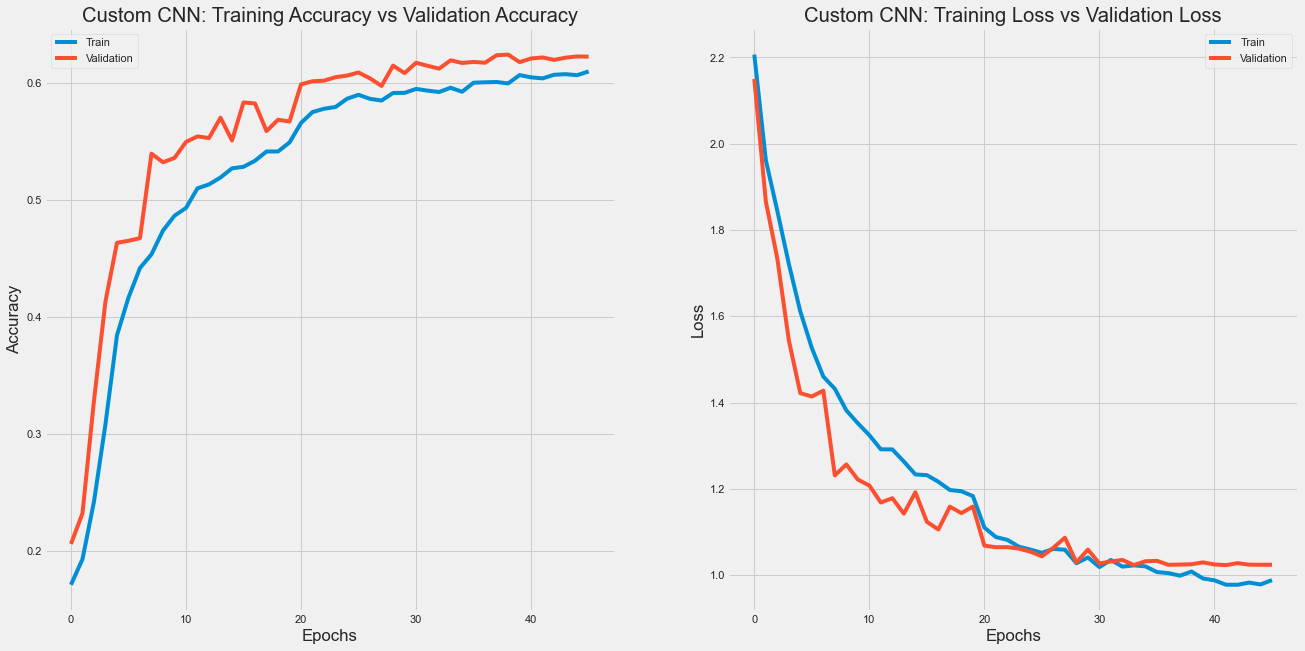

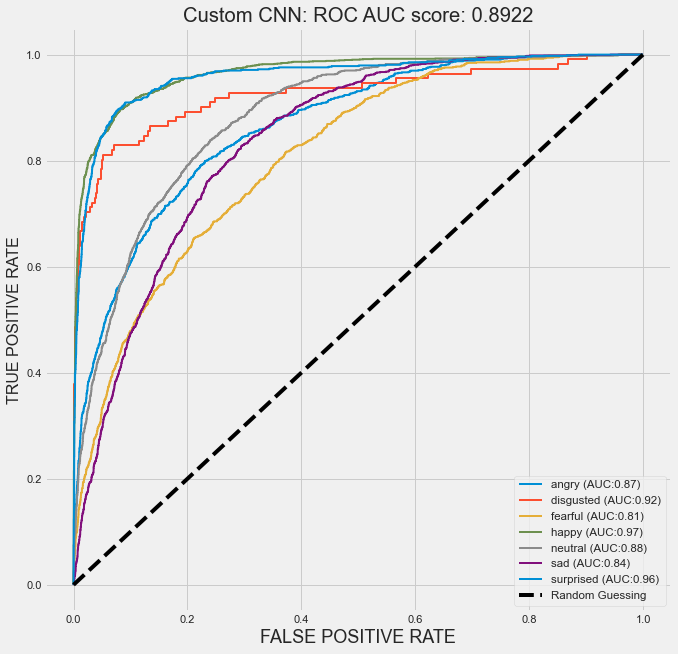

113/113 [==============================] - 4s 38ms/step


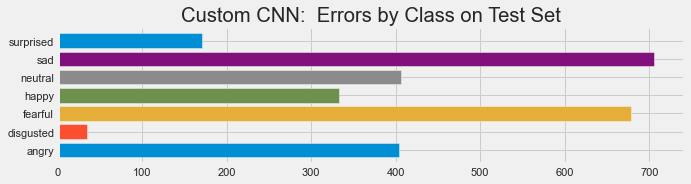

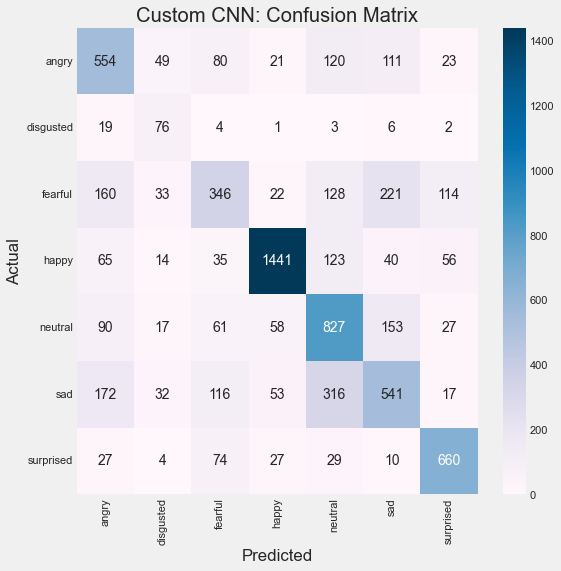

Custom CNN: Classification Report on Test Set:
----------------------
               precision    recall  f1-score   support

       angry       0.51      0.58      0.54       958
   disgusted       0.34      0.68      0.45       111
     fearful       0.48      0.34      0.40      1024
       happy       0.89      0.81      0.85      1774
     neutral       0.53      0.67      0.60      1233
         sad       0.50      0.43      0.46      1247
   surprised       0.73      0.79      0.76       831

    accuracy                           0.62      7178
   macro avg       0.57      0.62      0.58      7178
weighted avg       0.63      0.62      0.62      7178



In [149]:
# Plot the performances of the model
plot_model_performance(CNN, CNN_history, test_set, 'Custom CNN')

**Summary:** 
- Accuracy and Loss hit a plateau at around 30 and 21 epochs respectively, more epochs will not help the model.
- ROC AUC shows us that fearful and sad are the hardest class to separate and happy, surprised, disgusted are the easiest.
- Confusion matrix showed us that Sad images are often confused as Neutral by the Custom CNN.
- Classification report shows us that the model can classify each classes well without bias except for the fearful, disgusted, and sad class.
- Accuracy is decent at 62%

D:\Anaconda\envs\GPUenabled\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Predicted Class:  fearful
Probability:  tf.Tensor(
[[0.05661615 0.01602146 0.42562166 0.00670109 0.06876922 0.36882925
  0.0574412 ]], shape=(1, 7), dtype=float32)


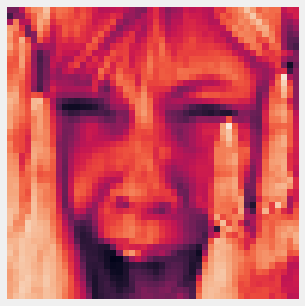

In [150]:
# Test the model on one sample image from the class fearful
classify_test(CNN_model, 'fearful')

**Result:** Correct prediction of fearful image

### Transfer Learning Models

Transfer Learning is a technique started by Stevo Bozinovski and Ante Fulgosi in 1976. It is a powerful technique where we an use a model that people have pre-trained and cut off the last layer and fit our own last layers while freezing the other layers of the pre-trained model for our own classification problem. This let us leverage the powerful models that big organizations have already built using millions of images and high complex archtecture to build a powerful emotion recognition CNN model, without training for a long period of time.

**Import Frozen pre-trained models**

In [43]:
from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.densenet import DenseNet169

**Initialize Frozen pre-trained models**

In [44]:
img_shape = (48,48,3)
channel = 3
# Call the pretrained models from keras
#Set weight = imagenet to use pre-trained models
VGG = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')
ResNet = ResNet50V2(input_shape=img_shape, include_top=False, weights='imagenet')
MobileNet = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
DenseNet = DenseNet169(input_shape=img_shape, include_top=False, weights='imagenet')

**Data fed into pre-trained models need to have 3 channels**

In [45]:
# Create new train, validation, test sets with 3 channels
train_set_3c = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (imheight, imwidth), 
                  batch_size = batch_size,
                  class_mode = 'categorical', # multiclass
                  subset = 'training', # set as training data
                  seed = 125,
                  shuffle = True)

validation_set_3c = valid_datagen.flow_from_directory(
                        train_dir,
                        target_size=(imheight, imwidth),
                        batch_size=batch_size,
                        class_mode = 'categorical',
                        subset='validation',
                        seed = 125,
                        shuffle=False) # set as validation data 

test_set_3c = test_datagen.flow_from_directory(
                    test_dir,
                    target_size =(imheight, imwidth),
                    batch_size = batch_size,
                    class_mode ='categorical',
                    shuffle=False)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Model 2: VGG16

In [46]:
# Freeze base Model
VGG.trainable = False

In [47]:
# Add our own defined layer into the last few layers of the model
VGG_full = Sequential([
    VGG,
    GlobalMaxPooling2D(),
    Dense(4096,activation="relu",kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(num_class, activation='softmax', name = 'Classifier')
])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense_3 (Dense)             (None, 4096)              2101248   
                                                                 
 dropout_6 (Dropout)         (None, 4096)              0         
                                                                 
 Classifier (Dense)          (None, 7)                 28679     
                                                                 
Total params: 16,844,615
Trainable params: 2,129,927
Non-trainable params: 14,714,688
__________________________________

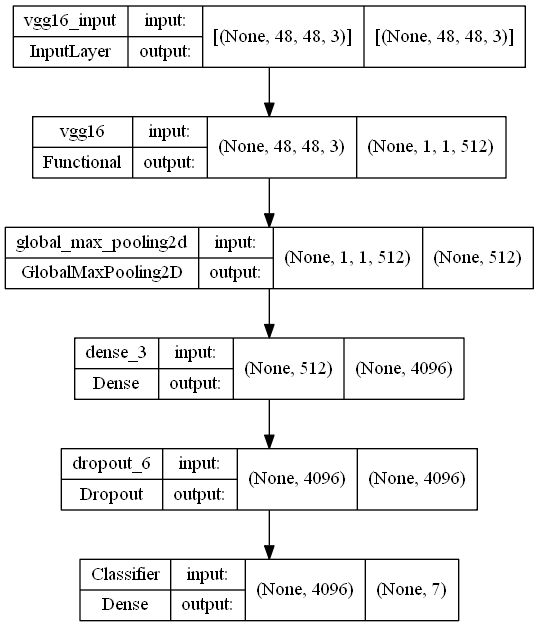

In [48]:
#View the new model architecture and number of trainable parameters
VGG_full.summary()
plot_model(VGG_full, 'VGG.png', show_shapes = True)

In [152]:
#Compile, train and evaluate model

VGG_checkpoint = ModelCheckpoint("./VGG.h5", monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')
VGG_callbacks = define_callbacks(VGG_checkpoint)

VGG_history = train_model(VGG_full, train_set_3c, validation_set_3c, test_set_3c, VGG_callbacks, epochs=40)

Epoch 1/40
359/359 [==============================] - ETA: 0s - loss: 1.7880 - accuracy: 0.3057 - precision_10: 0.4217 - recall_10: 0.0902 - auc_10: 0.7062
Epoch 1: val_accuracy improved from -inf to 0.37554, saving model to .\VGG.h5
359/359 [==============================] - 48s 127ms/step - loss: 1.7880 - accuracy: 0.3057 - precision_10: 0.4217 - recall_10: 0.0902 - auc_10: 0.7062 - val_loss: 1.6211 - val_accuracy: 0.3755 - val_precision_10: 0.6457 - val_recall_10: 0.0679 - val_auc_10: 0.7564 - lr: 0.0010
Epoch 2/40
359/359 [==============================] - ETA: 0s - loss: 1.6306 - accuracy: 0.3546 - precision_10: 0.5761 - recall_10: 0.0874 - auc_10: 0.7523
Epoch 2: val_accuracy did not improve from 0.37554
359/359 [==============================] - 62s 171ms/step - loss: 1.6306 - accuracy: 0.3546 - precision_10: 0.5761 - recall_10: 0.0874 - auc_10: 0.7523 - val_loss: 1.5972 - val_accuracy: 0.3674 - val_precision_10: 0.5741 - val_recall_10: 0.1282 - val_auc_10: 0.7651 - lr: 0.0010
E

Epoch 17/40
359/359 [==============================] - ETA: 0s - loss: 1.4291 - accuracy: 0.4538 - precision_10: 0.6881 - recall_10: 0.1765 - auc_10: 0.8201
Epoch 17: val_accuracy did not improve from 0.42919
359/359 [==============================] - 78s 217ms/step - loss: 1.4291 - accuracy: 0.4538 - precision_10: 0.6881 - recall_10: 0.1765 - auc_10: 0.8201 - val_loss: 1.5024 - val_accuracy: 0.4287 - val_precision_10: 0.6182 - val_recall_10: 0.2022 - val_auc_10: 0.7994 - lr: 4.0000e-05
Epoch 18/40
359/359 [==============================] - ETA: 0s - loss: 1.4340 - accuracy: 0.4520 - precision_10: 0.6874 - recall_10: 0.1770 - auc_10: 0.8185
Epoch 18: val_accuracy improved from 0.42919 to 0.43059, saving model to .\VGG.h5
359/359 [==============================] - 73s 204ms/step - loss: 1.4340 - accuracy: 0.4520 - precision_10: 0.6874 - recall_10: 0.1770 - auc_10: 0.8185 - val_loss: 1.5026 - val_accuracy: 0.4306 - val_precision_10: 0.6172 - val_recall_10: 0.1972 - val_auc_10: 0.7991 - l

Epoch 33/40
359/359 [==============================] - ETA: 0s - loss: 1.4182 - accuracy: 0.4564 - precision_10: 0.6956 - recall_10: 0.1840 - auc_10: 0.8232
Epoch 33: val_accuracy did not improve from 0.43424

Epoch 33: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
359/359 [==============================] - 66s 183ms/step - loss: 1.4182 - accuracy: 0.4564 - precision_10: 0.6956 - recall_10: 0.1840 - auc_10: 0.8232 - val_loss: 1.4980 - val_accuracy: 0.4341 - val_precision_10: 0.6192 - val_recall_10: 0.1986 - val_auc_10: 0.8007 - lr: 3.2000e-07
Epoch 34/40
359/359 [==============================] - ETA: 0s - loss: 1.4183 - accuracy: 0.4584 - precision_10: 0.6963 - recall_10: 0.1812 - auc_10: 0.8232
Epoch 34: val_accuracy did not improve from 0.43424
359/359 [==============================] - 86s 239ms/step - loss: 1.4183 - accuracy: 0.4584 - precision_10: 0.6963 - recall_10: 0.1812 - auc_10: 0.8232 - val_loss: 1.4980 - val_accuracy: 0.4342 - val_precision_10: 0.6192 

In [6]:
# Load the saved model
VGG_model = keras.models.load_model('VGG.h5')

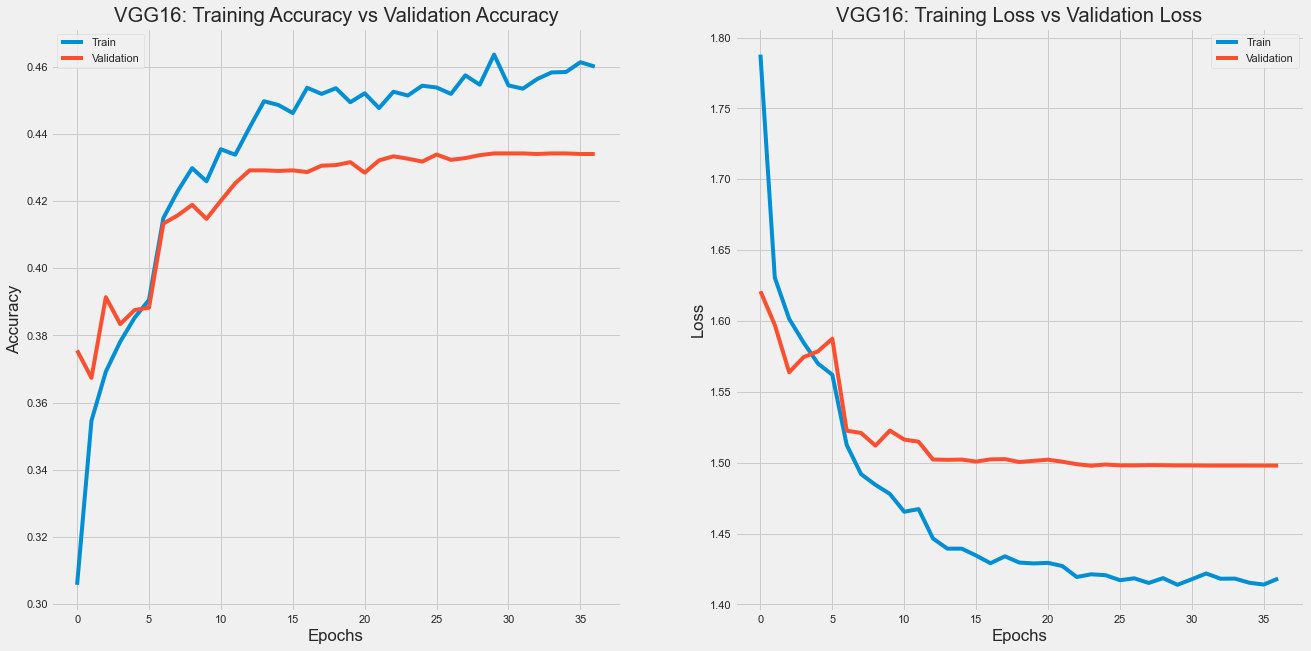

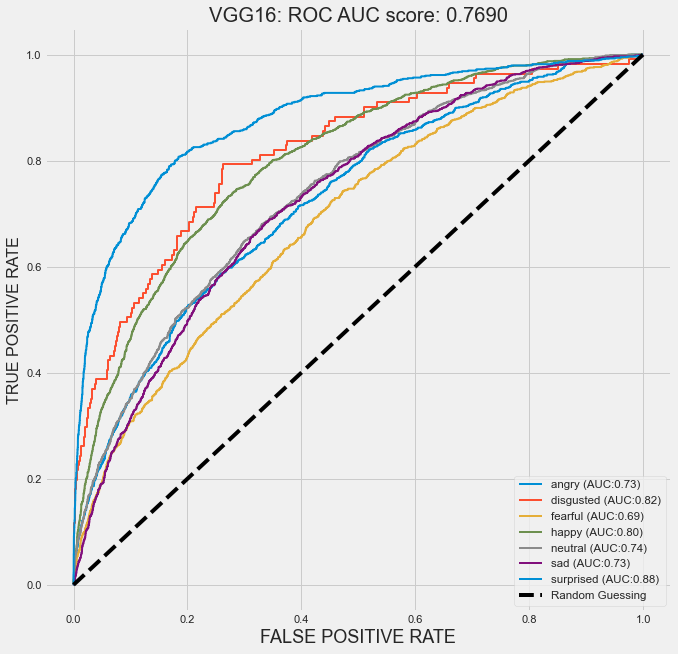

113/113 [==============================] - 8s 69ms/step


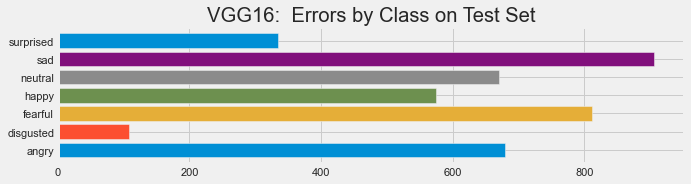

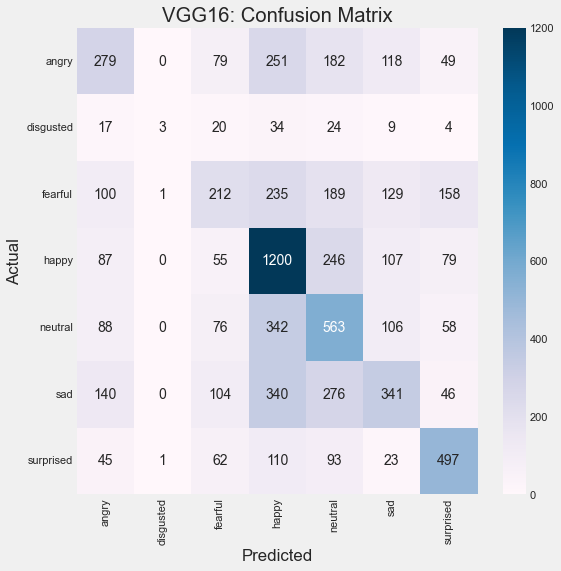

VGG16: Classification Report on Test Set:
----------------------
               precision    recall  f1-score   support

       angry       0.37      0.29      0.33       958
   disgusted       0.60      0.03      0.05       111
     fearful       0.35      0.21      0.26      1024
       happy       0.48      0.68      0.56      1774
     neutral       0.36      0.46      0.40      1233
         sad       0.41      0.27      0.33      1247
   surprised       0.56      0.60      0.58       831

    accuracy                           0.43      7178
   macro avg       0.45      0.36      0.36      7178
weighted avg       0.42      0.43      0.41      7178



In [154]:
# Plot the performance metrics and training history of VGG16
plot_model_performance(VGG_full, VGG_history, test_set_3c, 'VGG16')

**Summary:** 
- Validation Accuracy and Loss hit a plateau at 12 epochs, more epochs will not help the model.
- ROC AUC shows us that fearful and angry are the hardest class to separate and surprised the easiest.
- Confusion matrix showed us that Sad images are often confused as Neutral or Happy by the model.
- Classification report shows us that the F1 score for each class aree very low, hence it is not a good model to for generalizing to all classes.

Predicted Class:  fearful
Probability:  tf.Tensor(
[[0.17298366 0.00250567 0.4267868  0.04439804 0.0105395  0.2670889
  0.07569741]], shape=(1, 7), dtype=float32)


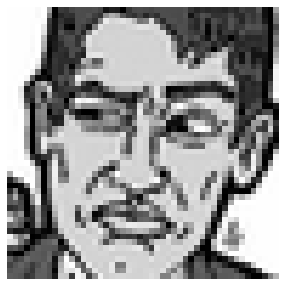

In [10]:
# Test VGG on a sample image
classify_test(VGG_model, 'angry', 3)

**Result:** Incorrect prediction, angry image predicted as fearful.

### Model 3: RestNet50V2

In [157]:
# Freeze base Model
ResNet.trainable = False

In [158]:
# Add our own defined layer into the last few layers of the model
ResNet_full = Sequential([
    ResNet,
    GlobalMaxPooling2D(),
    Dense(4096,activation="relu",kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(num_class, activation='softmax', name = 'Classifier')
])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_max_pooling2d_4 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_27 (Dense)            (None, 4096)              8392704   
                                                                 
 dropout_45 (Dropout)        (None, 4096)              0         
                                                                 
 Classifier (Dense)          (None, 7)                 28679     
                                                                 
Total params: 31,986,183
Trainable params: 8,421,383
Non-trainable params: 23,564,800
_________________________________

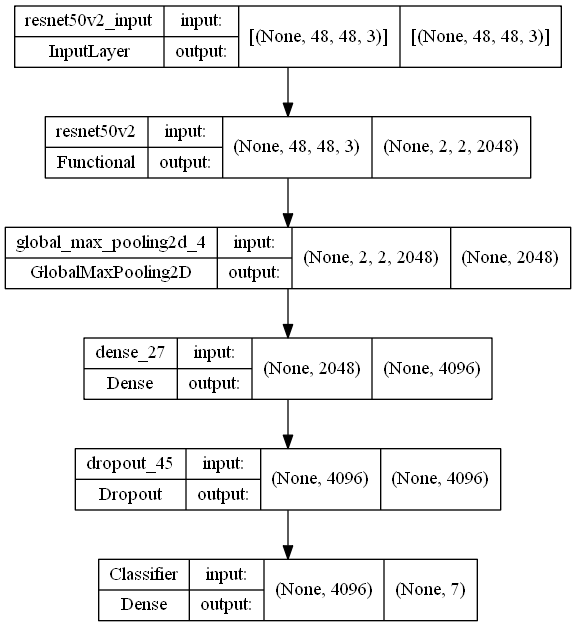

In [159]:
#View the new model architecture and number of trainable parameters
ResNet_full.summary()
plot_model(ResNet_full, 'ResNet.png', show_shapes = True)

In [160]:
#Compile, train and evaluate model

ResNet_checkpoint = ModelCheckpoint("./ResNet.h5", monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')
ResNet_callbacks = define_callbacks(ResNet_checkpoint)

ResNet_history = train_model(ResNet_full, train_set_3c, validation_set_3c, test_set_3c, ResNet_callbacks, epochs=40)


Epoch 1/40
359/359 [==============================] - ETA: 0s - loss: 2.3655 - accuracy: 0.3020 - precision_11: 0.3651 - recall_11: 0.1115 - auc_11: 0.6838
Epoch 1: val_accuracy improved from -inf to 0.36422, saving model to .\ResNet.h5
359/359 [==============================] - 69s 159ms/step - loss: 2.3655 - accuracy: 0.3020 - precision_11: 0.3651 - recall_11: 0.1115 - auc_11: 0.6838 - val_loss: 1.6339 - val_accuracy: 0.3642 - val_precision_11: 0.6182 - val_recall_11: 0.1162 - val_auc_11: 0.7501 - lr: 0.0010
Epoch 2/40
359/359 [==============================] - ETA: 0s - loss: 1.6617 - accuracy: 0.3431 - precision_11: 0.5443 - recall_11: 0.1010 - auc_11: 0.7421
Epoch 2: val_accuracy improved from 0.36422 to 0.38251, saving model to .\ResNet.h5
359/359 [==============================] - 61s 169ms/step - loss: 1.6617 - accuracy: 0.3431 - precision_11: 0.5443 - recall_11: 0.1010 - auc_11: 0.7421 - val_loss: 1.6007 - val_accuracy: 0.3825 - val_precision_11: 0.6328 - val_recall_11: 0.1129

Epoch 17/40
359/359 [==============================] - ETA: 0s - loss: 1.4851 - accuracy: 0.4215 - precision_11: 0.6673 - recall_11: 0.1743 - auc_11: 0.8015
Epoch 17: val_accuracy did not improve from 0.42902
359/359 [==============================] - 58s 161ms/step - loss: 1.4851 - accuracy: 0.4215 - precision_11: 0.6673 - recall_11: 0.1743 - auc_11: 0.8015 - val_loss: 1.5061 - val_accuracy: 0.4257 - val_precision_11: 0.6180 - val_recall_11: 0.2052 - val_auc_11: 0.7985 - lr: 2.0000e-04
Epoch 18/40
359/359 [==============================] - ETA: 0s - loss: 1.4902 - accuracy: 0.4220 - precision_11: 0.6613 - recall_11: 0.1747 - auc_11: 0.8002
Epoch 18: val_accuracy did not improve from 0.42902

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
359/359 [==============================] - 62s 172ms/step - loss: 1.4902 - accuracy: 0.4220 - precision_11: 0.6613 - recall_11: 0.1747 - auc_11: 0.8002 - val_loss: 1.5054 - val_accuracy: 0.4276 - val_precision_11: 0.6187

Epoch 32: early stopping
Time taken to train: 0:36:17.012004

Training scores: 
Loss:  1.4296
Accuracy:  0.4502
Precision:  0.6998
Recall:  0.1881
AUC:  0.8185

Validation scores: 
Loss:  1.4938
Accuracy:  0.4365
Precision:  0.6413
Recall:  0.1937
AUC:  0.8024

Test scores: 
Loss:  1.4847
Accuracy:  0.4271
Precision:  0.6575
Recall:  0.1957
AUC:  0.8028



In [161]:
# Load the saved model
ResNet_model = keras.models.load_model('ResNet.h5')

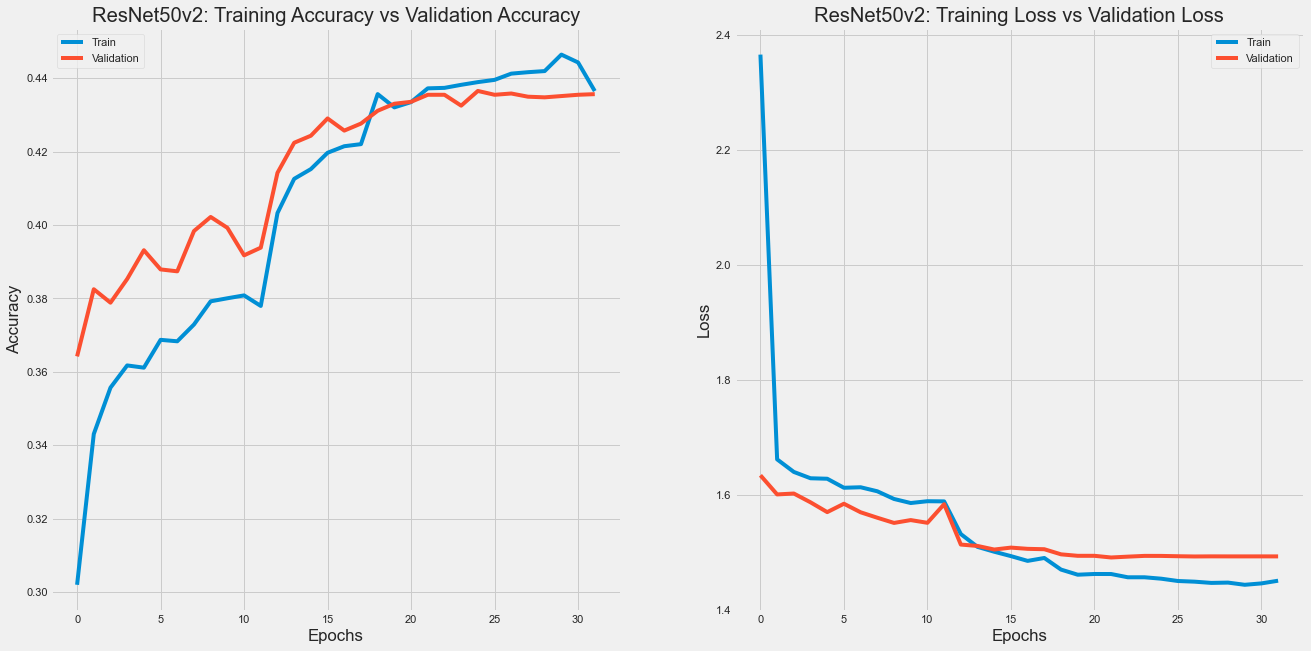

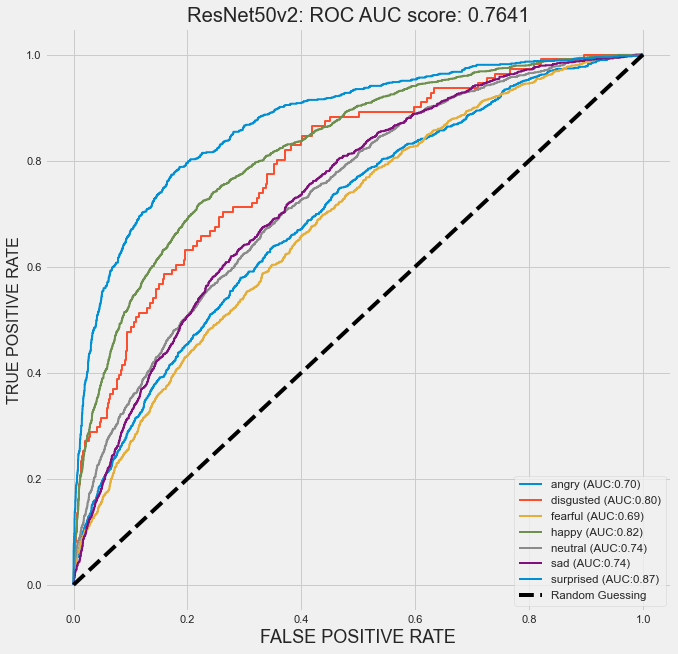

113/113 [==============================] - 7s 60ms/step


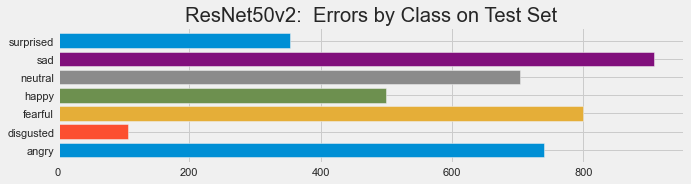

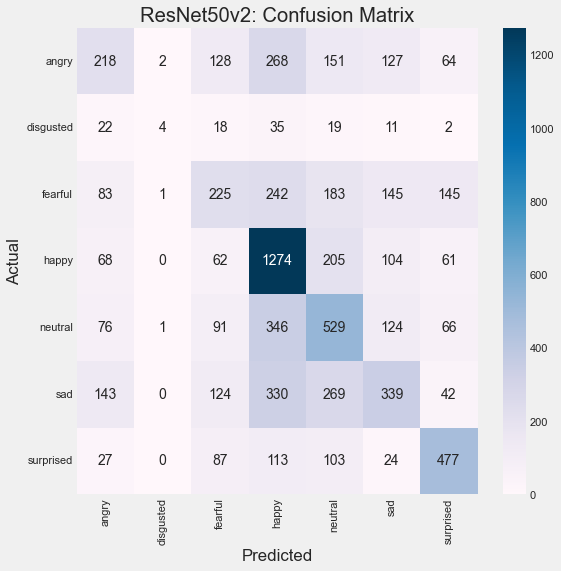

ResNet50v2: Classification Report on Test Set:
----------------------
               precision    recall  f1-score   support

       angry       0.34      0.23      0.27       958
   disgusted       0.50      0.04      0.07       111
     fearful       0.31      0.22      0.26      1024
       happy       0.49      0.72      0.58      1774
     neutral       0.36      0.43      0.39      1233
         sad       0.39      0.27      0.32      1247
   surprised       0.56      0.57      0.57       831

    accuracy                           0.43      7178
   macro avg       0.42      0.35      0.35      7178
weighted avg       0.41      0.43      0.41      7178



In [162]:
# Plot the performance metrics and training history of ResNet
plot_model_performance(ResNet_full, ResNet_history, test_set_3c, 'ResNet50v2')

**Summary:** 
- Validation Accuracy and Loss hit a plateau at 20 epochs, more epochs will not help the model.
- ROC AUC shows us that fearful and angry are the hardest class to separate and surprised the easiest.
- Confusion matrix showed us that Sad images are often confused as Neutral or Happy by the model.
- Classification report shows us that the F1 score for each classes are very low, hence it is not a good model to for generalizing to all classes.
- Accuracy is very low at only 43% 

Predicted Class:  happy
Probability:  tf.Tensor(
[[0.1777466  0.01979846 0.09236477 0.34697554 0.08841953 0.2588926
  0.01580252]], shape=(1, 7), dtype=float32)


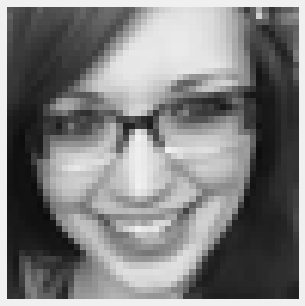

In [163]:
# Test ResNet on a sample image
classify_test(ResNet_model, 'happy', channel)

**Result:** Correct prediction on happy image.

### Model 4: MobileNetV2

In [166]:
# Freeze base model
MobileNet.trainable = False

In [171]:
# Add our own defined layer into the last few layers of the model
MobileNet_full = Sequential([
    MobileNet,
    GlobalMaxPooling2D(),
    Dense(4096,activation="relu",kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(num_class, activation='softmax', name = 'Classifier')
])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d_7 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_30 (Dense)            (None, 4096)              5246976   
                                                                 
 dropout_48 (Dropout)        (None, 4096)              0         
                                                                 
 Classifier (Dense)          (None, 7)                 28679     
                                                                 
Total params: 7,533,639
Trainable params: 5,275,655
N

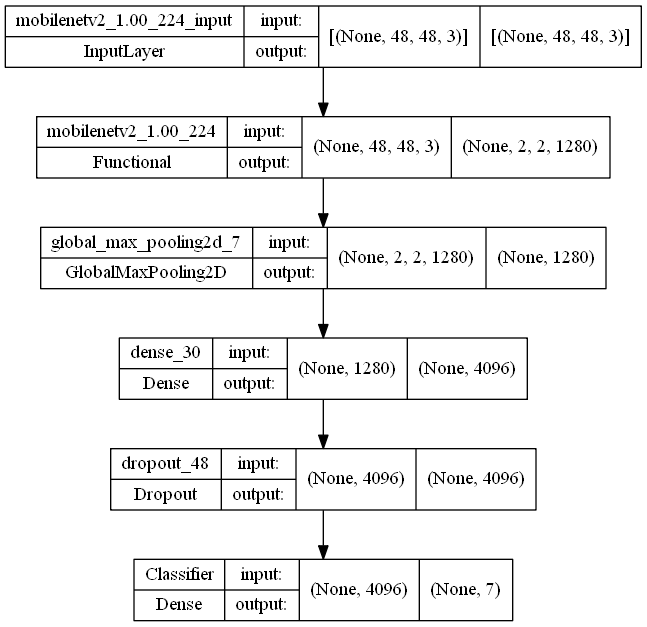

In [172]:
#View the new model architecture and number of trainable parameters
MobileNet_full.summary()
plot_model(MobileNet_full, 'MobileNet.png', show_shapes = True)

In [173]:
#Compile, train and evaluate model

MobileNet_checkpoint = ModelCheckpoint("./MobileNet.h5", monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')
MobileNet_callbacks = define_callbacks(MobileNet_checkpoint)

MobileNet_history = train_model(MobileNet_full, train_set_3c, validation_set_3c, test_set_3c, MobileNet_callbacks, epochs=40)

Epoch 1/40
359/359 [==============================] - ETA: 0s - loss: 2.7834 - accuracy: 0.2673 - precision_12: 0.3808 - recall_12: 0.0284 - auc_12: 0.6715
Epoch 1: val_accuracy improved from -inf to 0.28897, saving model to .\MobileNet.h5
359/359 [==============================] - 57s 145ms/step - loss: 2.7834 - accuracy: 0.2673 - precision_12: 0.3808 - recall_12: 0.0284 - auc_12: 0.6715 - val_loss: 1.6891 - val_accuracy: 0.2890 - val_precision_12: 0.6165 - val_recall_12: 0.0664 - val_auc_12: 0.7207 - lr: 0.0100
Epoch 2/40
359/359 [==============================] - ETA: 0s - loss: 1.7331 - accuracy: 0.2834 - precision_12: 0.5765 - recall_12: 0.0433 - auc_12: 0.6992
Epoch 2: val_accuracy improved from 0.28897 to 0.29873, saving model to .\MobileNet.h5
359/359 [==============================] - 54s 149ms/step - loss: 1.7331 - accuracy: 0.2834 - precision_12: 0.5765 - recall_12: 0.0433 - auc_12: 0.6992 - val_loss: 1.6789 - val_accuracy: 0.2987 - val_precision_12: 0.5818 - val_recall_12: 

Epoch 17/40
359/359 [==============================] - ETA: 0s - loss: 1.6769 - accuracy: 0.3151 - precision_12: 0.6134 - recall_12: 0.0675 - auc_12: 0.7266
Epoch 17: val_accuracy did not improve from 0.34628
359/359 [==============================] - 54s 149ms/step - loss: 1.6769 - accuracy: 0.3151 - precision_12: 0.6134 - recall_12: 0.0675 - auc_12: 0.7266 - val_loss: 1.6384 - val_accuracy: 0.3447 - val_precision_12: 0.6587 - val_recall_12: 0.0860 - val_auc_12: 0.7442 - lr: 4.0000e-04
Epoch 18/40
359/359 [==============================] - ETA: 0s - loss: 1.6729 - accuracy: 0.3214 - precision_12: 0.6244 - recall_12: 0.0684 - auc_12: 0.7273
Epoch 18: val_accuracy improved from 0.34628 to 0.35011, saving model to .\MobileNet.h5
359/359 [==============================] - 46s 127ms/step - loss: 1.6729 - accuracy: 0.3214 - precision_12: 0.6244 - recall_12: 0.0684 - auc_12: 0.7273 - val_loss: 1.6339 - val_accuracy: 0.3501 - val_precision_12: 0.6715 - val_recall_12: 0.0812 - val_auc_12: 0.74

In [174]:
# Load the saved model

MobileNet_model = keras.models.load_model('MobileNet.h5')

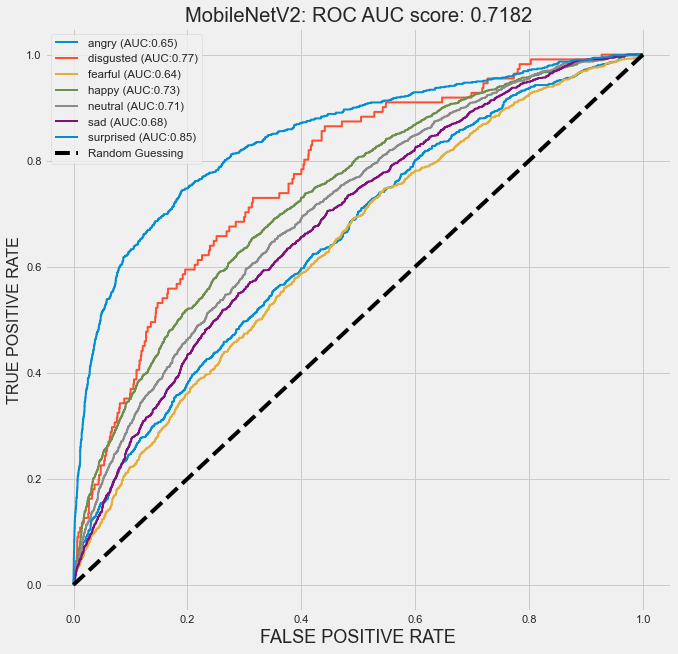

113/113 [==============================] - 4s 38ms/step


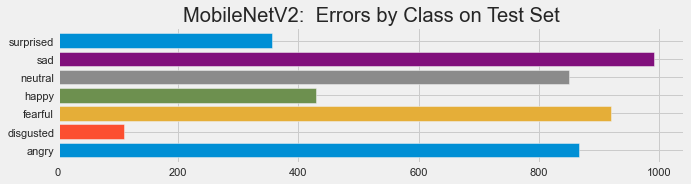

MobileNetV2: Classification Report on Test Set:
----------------------
               precision    recall  f1-score   support

       angry       0.37      0.09      0.15       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.29      0.10      0.15      1024
       happy       0.35      0.76      0.48      1774
     neutral       0.36      0.31      0.33      1233
         sad       0.35      0.20      0.26      1247
   surprised       0.50      0.57      0.53       831

    accuracy                           0.37      7178
   macro avg       0.32      0.29      0.27      7178
weighted avg       0.36      0.37      0.32      7178



D:\Anaconda\envs\GPUenabled\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\GPUenabled\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\GPUenabled\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [175]:
# Plot the performance metrics and training history of MobileNet

plot_model_performance(MobileNet_full, MobileNet_history, test_set_3c, 'MobileNetV2')

**Summary:** 
- Accuracy improves continuously but the Loss hit did not improve much after around 5 epochs, hence more epochs wont make the model better.
- ROC AUC shows us that fearful and angry are the hardest class to separate and surprised the easiest.
- Confusion matrix showed us that Sad images are predicted as Happy more than sad by the model.
- Classification report shows us that the F1 score for each class aree very low, hence it is not a good model to for generalizing to all classes.
- Accuracy is very low at only 37% 

In [176]:
# Test MobielNet on a sample image

classify_test(MobileNet_model, 'disgusted', channel)

Predicted Class:  angry
Probability:  tf.Tensor(
[[0.27706075 0.04677242 0.1812082  0.1309423  0.14142826 0.17676958
  0.04581854]], shape=(1, 7), dtype=float32)


**Result:** Incorrect prediction, disgusted image predicted as angry.

### Model 5: DenseNet169

In [177]:
# Freeze base model
DenseNet.trainable = False

In [178]:
# Add our own defined layer into the last few layers of the model
DenseNet_full = Sequential([
    DenseNet,
    GlobalMaxPooling2D(),
    Dense(4096,activation="relu",kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(num_class, activation='softmax', name = 'Classifier')
])

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1, 1, 1664)        12642880  
                                                                 
 global_max_pooling2d_8 (Glo  (None, 1664)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_31 (Dense)            (None, 4096)              6819840   
                                                                 
 dropout_49 (Dropout)        (None, 4096)              0         
                                                                 
 Classifier (Dense)          (None, 7)                 28679     
                                                                 
Total params: 19,491,399
Trainable params: 6,848,519
Non-trainable params: 12,642,880
_________________________________

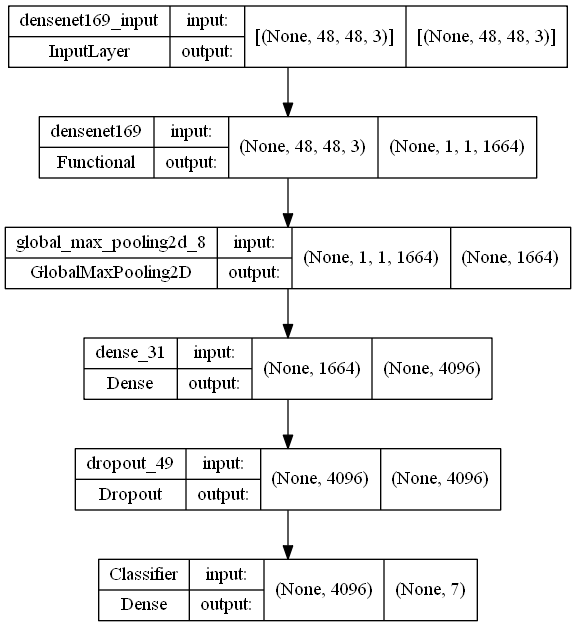

In [179]:
DenseNet_full.summary()
plot_model(DenseNet_full, 'DenseNet.png', show_shapes = True)

In [180]:
#Compile, train and evaluate model

DenseNet_checkpoint = ModelCheckpoint("./DenseNet.h5", monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')
DenseNet_callbacks = define_callbacks(DenseNet_checkpoint)

DenseNet_history = train_model(DenseNet_full, train_set_3c, validation_set_3c, test_set_3c, DenseNet_callbacks, epochs=40)

Epoch 1/40
359/359 [==============================] - ETA: 0s - loss: 2.1172 - accuracy: 0.3030 - precision_13: 0.4743 - recall_13: 0.0513 - auc_13: 0.7005
Epoch 1: val_accuracy improved from -inf to 0.35133, saving model to .\DenseNet.h5
359/359 [==============================] - 67s 151ms/step - loss: 2.1172 - accuracy: 0.3030 - precision_13: 0.4743 - recall_13: 0.0513 - auc_13: 0.7005 - val_loss: 1.6395 - val_accuracy: 0.3513 - val_precision_13: 0.5879 - val_recall_13: 0.1200 - val_auc_13: 0.7459 - lr: 0.0100
Epoch 2/40
359/359 [==============================] - ETA: 0s - loss: 1.6788 - accuracy: 0.3311 - precision_13: 0.5985 - recall_13: 0.0741 - auc_13: 0.7268
Epoch 2: val_accuracy improved from 0.35133 to 0.36213, saving model to .\DenseNet.h5
359/359 [==============================] - 49s 138ms/step - loss: 1.6788 - accuracy: 0.3311 - precision_13: 0.5985 - recall_13: 0.0741 - auc_13: 0.7268 - val_loss: 1.6258 - val_accuracy: 0.3621 - val_precision_13: 0.6141 - val_recall_13: 0.

359/359 [==============================] - ETA: 0s - loss: 1.5876 - accuracy: 0.3696 - precision_13: 0.6556 - recall_13: 0.1126 - auc_13: 0.7649
Epoch 33: val_accuracy did not improve from 0.40986
359/359 [==============================] - 65s 179ms/step - loss: 1.5876 - accuracy: 0.3696 - precision_13: 0.6556 - recall_13: 0.1126 - auc_13: 0.7649 - val_loss: 1.5313 - val_accuracy: 0.4071 - val_precision_13: 0.6631 - val_recall_13: 0.1611 - val_auc_13: 0.7857 - lr: 4.0000e-04
Epoch 34/40
359/359 [==============================] - ETA: 0s - loss: 1.5818 - accuracy: 0.3792 - precision_13: 0.6402 - recall_13: 0.1139 - auc_13: 0.7675
Epoch 34: val_accuracy did not improve from 0.40986
359/359 [==============================] - 64s 177ms/step - loss: 1.5818 - accuracy: 0.3792 - precision_13: 0.6402 - recall_13: 0.1139 - auc_13: 0.7675 - val_loss: 1.5296 - val_accuracy: 0.4074 - val_precision_13: 0.6822 - val_recall_13: 0.1477 - val_auc_13: 0.7865 - lr: 4.0000e-04
Epoch 35/40
359/359 [=======

In [181]:
# Load the saved model

DenseNet_model = keras.models.load_model('DenseNet.h5')

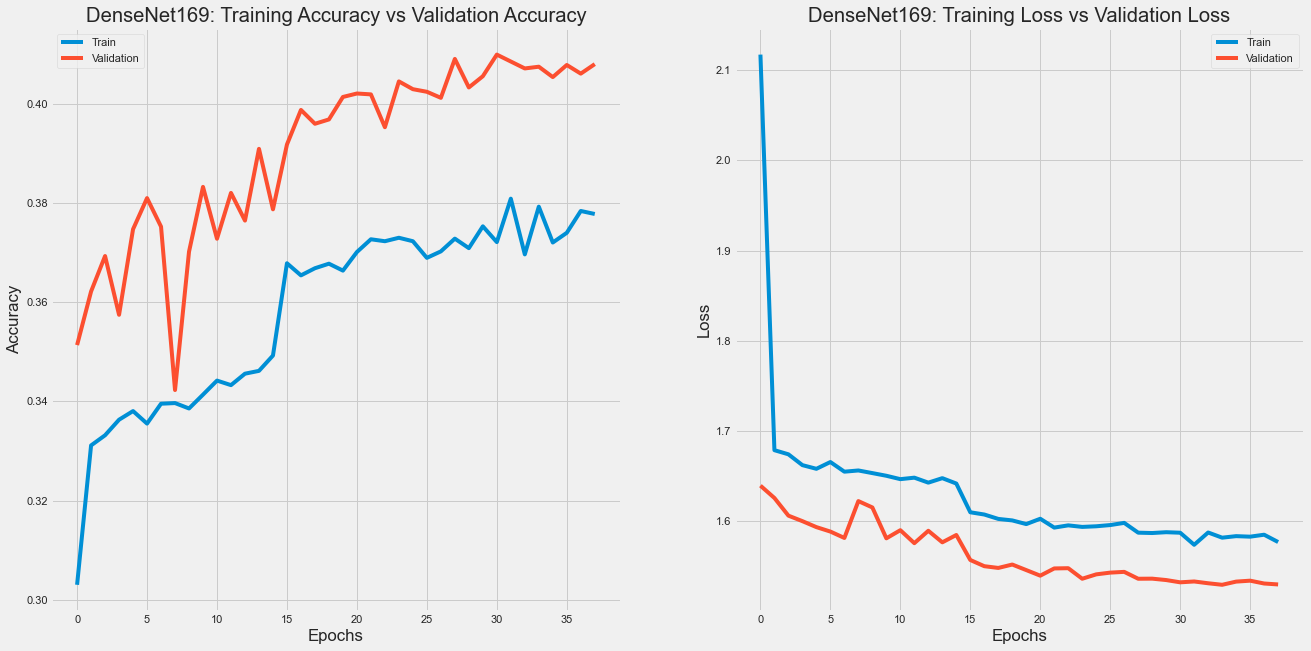

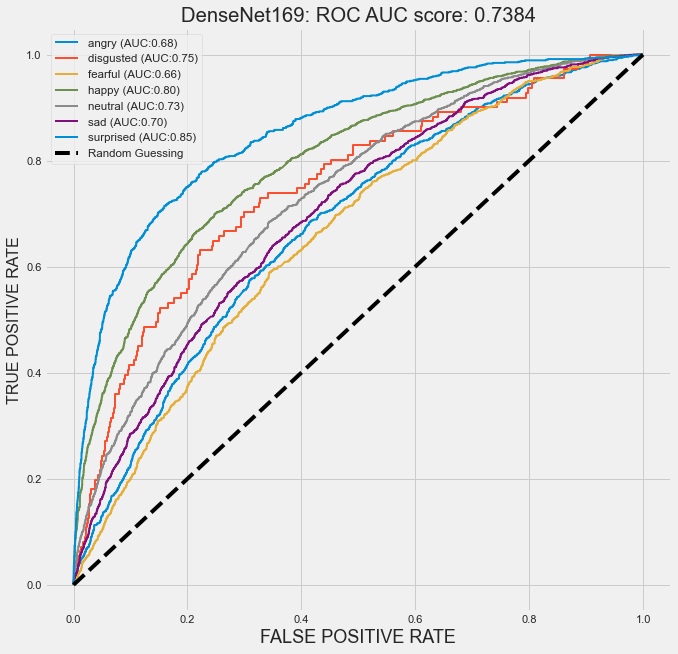

113/113 [==============================] - 8s 72ms/step


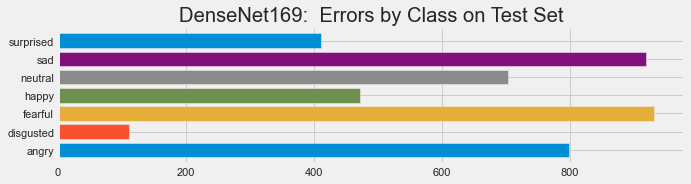

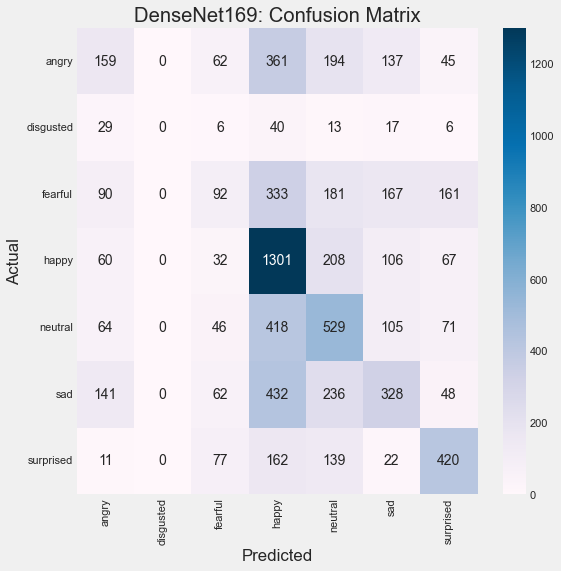

DenseNet169: Classification Report on Test Set:
----------------------
               precision    recall  f1-score   support

       angry       0.29      0.17      0.21       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.24      0.09      0.13      1024
       happy       0.43      0.73      0.54      1774
     neutral       0.35      0.43      0.39      1233
         sad       0.37      0.26      0.31      1247
   surprised       0.51      0.51      0.51       831

    accuracy                           0.39      7178
   macro avg       0.31      0.31      0.30      7178
weighted avg       0.36      0.39      0.36      7178



D:\Anaconda\envs\GPUenabled\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\GPUenabled\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\GPUenabled\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [182]:
# Plot the performance metrics and training history of DenseNet

plot_model_performance(DenseNet_full, DenseNet_history, test_set_3c, 'DenseNet169')

**Summary:** 
- Moving average of validation Accuracy and Loss hit a plateau at around 30 epochs, more epochs will not help the model.
- ROC AUC shows us that fearful and angry are the hardest class to separate and surprised the easiest.
- Confusion matrix showed us that Sad images are often confused as Neutral or Happy by the model.
- Classification report shows us that the F1 score for each class are very low, hence it is not a good model to for generalizing to all classes.
- Accuracy is very low at only 39% 

Predicted Class:  fearful
Probability:  tf.Tensor(
[[0.13184445 0.01590823 0.33979842 0.09879296 0.07385638 0.07510732
  0.26469225]], shape=(1, 7), dtype=float32)


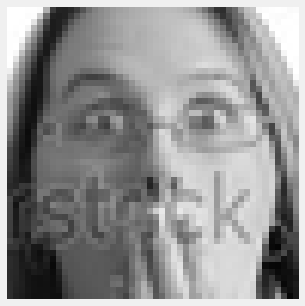

In [183]:
# Test DenseNet on a sample image

classify_test(DenseNet_model, 'surprised', channel)

**Result:** Incorrect prediction, surprised image classified as fearful

# Part D: Hyperparameter Tuning on Our Best Model: CNN

To our surprise, the best model trained using the initial hyperparameter is our own custom built CNN. This is because our custom CNN can perform well even if we pass the class_weights hyperparameter into training. The other models achieved less than 20% when we pass in class_weights. And even without class_weights, they can only achieve around 40% accuracy. In this final phase, we will be tuning the hyper parameters and train the Custom CNN again. Hopefully, it will achieve higher accuracy than 62% and learn the representation of our dataset better.

Hyperparameters to tune:
1. Reduce Learning rate to 0.001
2. Adding one more hidden layer
3. Adding more neurons to hidden layers from 128 to 256
4. Adding more filters to the last convolution block from 256 to 512
5. Reduce Batch Size to 32
6. Use 70 Epochs
7. Use different optimization algorithms and cross validate:
 - SGD
 - SGD with Nesterov Acceleration
 - RMSprop
 - Adam with Nesterov Acceleration

**Explanation:** Smaller learning rate means the model will converge slower but it will not overshoot, therefore guarantee a convergence. Next, we only tested using Adam in Part C, however there might be a better optimizer for our problem. Third, we will reduce the batch size because this allows the model to update the weights more frequently, although it will make training time slower. 

In [84]:
# Table of hyperparameters to tune
hyperparameters = {'Hyperparameters':['Learning Rate', 'Hidden layers', 'Neurons in hidden layer', 'Filters in last convolution block', 'Batch Size', 'Epochs', 'Optimizers'], 
                   'Values':['0.001', '2+1 layers', 'From 128 to 256', 'From 256 to 512','32','70','Adam, SGD, SGD+Nesterov, Nadam, RMSprop']}  

hyperparameter_table = pd.DataFrame(hyperparameters, index =['1.', '2.', '3.', '4.', '5.', '6.', '7.'])
hyperparameter_table

Hyperparameters                                   Values
1.                      Learning Rate                                    0.001
2.                      Hidden layers                               2+1 layers
3.            Neurons in hidden layer                          From 128 to 256
4.  Filters in last convolution block                          From 256 to 512
5.                         Batch Size                                       32
6.                             Epochs                                       70
7.                         Optimizers  Adam, SGD, SGD+Nesterov, Nadam, RMSprop

**Design a new CNN architecture with even more complexity**

In [75]:
# Function to build the architecture of the CNN for Hyperparameter Tuning

def CNN_architecture(CNN):
    # Feature Learning Part
    # Block-1
    CNN.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
    CNN.add(Activation('relu'))
    CNN.add(BatchNormalization())
    CNN.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
    CNN.add(Activation('relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling2D(pool_size=(2,2)))
    CNN.add(Dropout(0.2))

    # Block-2 

    CNN.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
    CNN.add(Activation('relu'))
    CNN.add(BatchNormalization())
    CNN.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
    CNN.add(Activation('relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling2D(pool_size=(2,2)))
    CNN.add(Dropout(0.2))

    # Block-3

    CNN.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
    CNN.add(Activation('relu'))
    CNN.add(BatchNormalization())
    CNN.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
    CNN.add(Activation('relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling2D(pool_size=(2,2)))
    CNN.add(Dropout(0.2))

    # Block-4 

    CNN.add(Conv2D(512,(3,3),padding='same',kernel_initializer='he_normal')) # From 256 to 512
    CNN.add(Activation('relu'))
    CNN.add(BatchNormalization())
    CNN.add(Conv2D(512,(3,3),padding='same',kernel_initializer='he_normal')) # From 256 to 512
    CNN.add(Activation('relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling2D(pool_size=(2,2)))
    CNN.add(Dropout(0.2))

    # Classification Part
    # Block-1

    CNN.add(Flatten())
    CNN.add(Dense(256,kernel_initializer='he_normal')) # From 128 to 256
    CNN.add(Activation('relu'))
    CNN.add(BatchNormalization())
    CNN.add(Dropout(0.2))

    # Block-2

    CNN.add(Dense(256,kernel_initializer='he_normal')) # From 128 to 256
    CNN.add(Activation('relu'))
    CNN.add(BatchNormalization())
    CNN.add(Dropout(0.2))

    # Block-3 --> Added layer

    CNN.add(Dense(256,kernel_initializer='he_normal')) # From 128 to 256
    CNN.add(Activation('relu'))
    CNN.add(BatchNormalization())
    CNN.add(Dropout(0.2))

    # Block-4 

    CNN.add(Dense(7,kernel_initializer='he_normal'))
    CNN.add(Activation('softmax')) # Softmax activation since we are doing multiclass classification
    
    return CNN

**Initialize all CNN models that will be using different optimizers**

In [76]:
# Intialize all CNN with different optimizers
CNN_Adam = Sequential()
CNN_SGD = Sequential()
CNN_NSGD = Sequential() # SGD With Nesterov Acceleration
CNN_Nadam = Sequential() # Adam With Nesterov Acceleration
CNN_RMSprop = Sequential()

**Explanation:** All the models above have the same architecture, but will be using different optimization algorithms.

**Build the model architectures**

In [77]:
# Call the CNN_architecture function to build all the model architectures
CNN_SGD = CNN_architecture(CNN_SGD)
CNN_NSGD = CNN_architecture(CNN_NSGD)
CNN_Adam = CNN_architecture(CNN_Adam)
CNN_Nadam = CNN_architecture(CNN_Nadam)
CNN_RMSprop = CNN_architecture(CNN_RMSprop)

### Training the CNNs using different optimizers

All models below will be trained using 70 epochs, 10 more than in Part C

We will train the model with Adam first because we used Adam in Part C, this will help us if tuning the other hyperparameters will yield better results than the first time. Previously the accuracy was 62% on the test set. If the accuracy increased, then we can proceed to experiment with other optimization algorithms.

#### 1. CNN with Adam

In [83]:
# Training CNN with Adam
# Make sure a 'Tuned_models' folder is created in the same directory as this ipynb file to run below codes

# Save the tuned model to a new folder 'Tuned_models'
CNN_Adam_checkpoint = ModelCheckpoint("./Tuned_models/CNN_Adam.h5", monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')
CNN_Adam_callbacks = define_callbacks(CNN_Adam_checkpoint)

CNN_Adam_history = train_model(CNN_Adam, train_set, validation_set, test_set, CNN_Adam_callbacks, class_weights, epochs=70)

Epoch 1/70
359/359 [==============================] - ETA: 0s - loss: 2.2165 - accuracy: 0.1618 - precision_2: 0.1462 - recall_2: 0.0205 - auc_2: 0.5410
Epoch 1: val_accuracy improved from -inf to 0.04198, saving model to ./Tuned_models\CNN_Adam.h5
359/359 [==============================] - 34s 89ms/step - loss: 2.2165 - accuracy: 0.1618 - precision_2: 0.1462 - recall_2: 0.0205 - auc_2: 0.5410 - val_loss: 2.0806 - val_accuracy: 0.0420 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_2: 0.4900 - lr: 0.0010
Epoch 2/70
359/359 [==============================] - ETA: 0s - loss: 2.0177 - accuracy: 0.1794 - precision_2: 0.2056 - recall_2: 0.0138 - auc_2: 0.5743
Epoch 2: val_accuracy improved from 0.04198 to 0.20815, saving model to ./Tuned_models\CNN_Adam.h5
359/359 [==============================] - 36s 100ms/step - loss: 2.0177 - accuracy: 0.1794 - precision_2: 0.2056 - recall_2: 0.0138 - auc_2: 0.5743 - val_loss: 1.8686 - val_accuracy: 0.2082 - val_precision_2: 0.5756 - 

Epoch 17/70
359/359 [==============================] - ETA: 0s - loss: 1.2110 - accuracy: 0.5330 - precision_2: 0.7104 - recall_2: 0.3396 - auc_2: 0.8686
Epoch 17: val_accuracy did not improve from 0.56610
359/359 [==============================] - 45s 126ms/step - loss: 1.2110 - accuracy: 0.5330 - precision_2: 0.7104 - recall_2: 0.3396 - auc_2: 0.8686 - val_loss: 1.1799 - val_accuracy: 0.5602 - val_precision_2: 0.6882 - val_recall_2: 0.4144 - val_auc_2: 0.8830 - lr: 0.0010
Epoch 18/70
359/359 [==============================] - ETA: 0s - loss: 1.1903 - accuracy: 0.5378 - precision_2: 0.7099 - recall_2: 0.3514 - auc_2: 0.8719
Epoch 18: val_accuracy did not improve from 0.56610

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
359/359 [==============================] - 48s 133ms/step - loss: 1.1903 - accuracy: 0.5378 - precision_2: 0.7099 - recall_2: 0.3514 - auc_2: 0.8719 - val_loss: 1.1847 - val_accuracy: 0.5539 - val_precision_2: 0.6652 - val_recall_2: 0.4

Epoch 33/70
359/359 [==============================] - ETA: 0s - loss: 0.9087 - accuracy: 0.6296 - precision_2: 0.7546 - recall_2: 0.4909 - auc_2: 0.9188
Epoch 33: val_accuracy improved from 0.62916 to 0.63351, saving model to ./Tuned_models\CNN_Adam.h5
359/359 [==============================] - 55s 152ms/step - loss: 0.9087 - accuracy: 0.6296 - precision_2: 0.7546 - recall_2: 0.4909 - auc_2: 0.9188 - val_loss: 0.9897 - val_accuracy: 0.6335 - val_precision_2: 0.7397 - val_recall_2: 0.5192 - val_auc_2: 0.9188 - lr: 2.0000e-04
Epoch 34/70
359/359 [==============================] - ETA: 0s - loss: 0.8990 - accuracy: 0.6330 - precision_2: 0.7559 - recall_2: 0.4964 - auc_2: 0.9199
Epoch 34: val_accuracy did not improve from 0.63351
359/359 [==============================] - 49s 135ms/step - loss: 0.8990 - accuracy: 0.6330 - precision_2: 0.7559 - recall_2: 0.4964 - auc_2: 0.9199 - val_loss: 0.9993 - val_accuracy: 0.6312 - val_precision_2: 0.7343 - val_recall_2: 0.5205 - val_auc_2: 0.9174 - l

**Interpretation:** The accuracy increased by 1% on the test set, and the validation set as well, this proves that reducing the learning rate to 0.001, batch_size to 32, more hidden layers, more neurons, and more filters will improve the model performance. Now we can proceed to experiment with different optimizers using these hyperparameters.

#### 2. CNN with SGD

In [86]:
# Training CNN with SGD

# Save the tuned model to a new folder 'Tuned_models'
CNN_SGD_checkpoint = ModelCheckpoint("./Tuned_models/CNN_SGD.h5", monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')
CNN_SGD_callbacks = define_callbacks(CNN_SGD_checkpoint)

CNN_SGD_history = train_model(CNN_SGD, train_set, validation_set, test_set, CNN_SGD_callbacks, class_weights, epochs=70)

Epoch 1/70
359/359 [==============================] - ETA: 0s - loss: 1.9974 - accuracy: 0.1907 - precision_3: 0.2554 - recall_3: 0.0164 - auc_3: 0.5747
Epoch 1: val_accuracy improved from -inf to 0.18115, saving model to ./Tuned_models\CNN_SGD.h5
359/359 [==============================] - 31s 82ms/step - loss: 1.9974 - accuracy: 0.1907 - precision_3: 0.2554 - recall_3: 0.0164 - auc_3: 0.5747 - val_loss: 1.9264 - val_accuracy: 0.1812 - val_precision_3: 0.4706 - val_recall_3: 0.0098 - val_auc_3: 0.5902 - lr: 0.0010
Epoch 2/70
359/359 [==============================] - ETA: 0s - loss: 1.9904 - accuracy: 0.1876 - precision_3: 0.2337 - recall_3: 0.0141 - auc_3: 0.5772
Epoch 2: val_accuracy improved from 0.18115 to 0.18289, saving model to ./Tuned_models\CNN_SGD.h5
359/359 [==============================] - 30s 84ms/step - loss: 1.9904 - accuracy: 0.1876 - precision_3: 0.2337 - recall_3: 0.0141 - auc_3: 0.5772 - val_loss: 1.9256 - val_accuracy: 0.1829 - val_precision_3: 0.4545 - val_recall_

359/359 [==============================] - 45s 126ms/step - loss: 1.8910 - accuracy: 0.2110 - precision_3: 0.3711 - recall_3: 0.0175 - auc_3: 0.6079 - val_loss: 1.8814 - val_accuracy: 0.2069 - val_precision_3: 0.3670 - val_recall_3: 0.0260 - val_auc_3: 0.6331 - lr: 0.0010
Epoch 18/70
359/359 [==============================] - ETA: 0s - loss: 1.8925 - accuracy: 0.2137 - precision_3: 0.3675 - recall_3: 0.0170 - auc_3: 0.6069
Epoch 18: val_accuracy did not improve from 0.21895
359/359 [==============================] - 45s 124ms/step - loss: 1.8925 - accuracy: 0.2137 - precision_3: 0.3675 - recall_3: 0.0170 - auc_3: 0.6069 - val_loss: 1.8782 - val_accuracy: 0.2127 - val_precision_3: 0.3747 - val_recall_3: 0.0263 - val_auc_3: 0.6351 - lr: 0.0010
Epoch 19/70
359/359 [==============================] - ETA: 0s - loss: 1.8863 - accuracy: 0.2149 - precision_3: 0.3566 - recall_3: 0.0153 - auc_3: 0.6122
Epoch 19: val_accuracy did not improve from 0.21895

Epoch 19: ReduceLROnPlateau reducing lear

**Interpretation:** Very low accuracy, precision, recall, AUC on all sets, SGD may not be the best optimizer.

#### 3. CNN with SGD + Nesterov

In [89]:
# Training CNN with Nesterov SGD

# Save the tuned model to a new folder 'Tuned_models'
CNN_NSGD_checkpoint = ModelCheckpoint("./Tuned_models/CNN_NSGD.h5", monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')
CNN_NSGD_callbacks = define_callbacks(CNN_SGD_checkpoint)

CNN_NSGD_history = train_model(CNN_NSGD, train_set, validation_set, test_set, CNN_NSGD_callbacks, class_weights, epochs=70)

Epoch 1/70
359/359 [==============================] - ETA: 0s - loss: 1.9333 - accuracy: 0.1998 - precision_4: 0.3038 - recall_4: 0.0158 - auc_4: 0.5946
Epoch 1: val_accuracy improved from 0.21895 to 0.24281, saving model to ./Tuned_models\CNN_SGD.h5
359/359 [==============================] - 33s 83ms/step - loss: 1.9333 - accuracy: 0.1998 - precision_4: 0.3038 - recall_4: 0.0158 - auc_4: 0.5946 - val_loss: 1.8368 - val_accuracy: 0.2428 - val_precision_4: 0.5388 - val_recall_4: 0.0218 - val_auc_4: 0.6516 - lr: 0.0010
Epoch 2/70
359/359 [==============================] - ETA: 0s - loss: 1.9131 - accuracy: 0.2014 - precision_4: 0.3382 - recall_4: 0.0170 - auc_4: 0.6037
Epoch 2: val_accuracy did not improve from 0.24281
359/359 [==============================] - 32s 88ms/step - loss: 1.9131 - accuracy: 0.2014 - precision_4: 0.3382 - recall_4: 0.0170 - auc_4: 0.6037 - val_loss: 1.8469 - val_accuracy: 0.2379 - val_precision_4: 0.4738 - val_recall_4: 0.0441 - val_auc_4: 0.6447 - lr: 0.0010
E

Epoch 17/70
359/359 [==============================] - ETA: 0s - loss: 1.7638 - accuracy: 0.2678 - precision_4: 0.4920 - recall_4: 0.0362 - auc_4: 0.6733
Epoch 17: val_accuracy improved from 0.30273 to 0.31144, saving model to ./Tuned_models\CNN_SGD.h5
359/359 [==============================] - 44s 123ms/step - loss: 1.7638 - accuracy: 0.2678 - precision_4: 0.4920 - recall_4: 0.0362 - auc_4: 0.6733 - val_loss: 1.7214 - val_accuracy: 0.3114 - val_precision_4: 0.5309 - val_recall_4: 0.0584 - val_auc_4: 0.7157 - lr: 2.0000e-04
Epoch 18/70
359/359 [==============================] - ETA: 0s - loss: 1.7581 - accuracy: 0.2703 - precision_4: 0.4967 - recall_4: 0.0364 - auc_4: 0.6769
Epoch 18: val_accuracy did not improve from 0.31144
359/359 [==============================] - 45s 125ms/step - loss: 1.7581 - accuracy: 0.2703 - precision_4: 0.4967 - recall_4: 0.0364 - auc_4: 0.6769 - val_loss: 1.7405 - val_accuracy: 0.3010 - val_precision_4: 0.4975 - val_recall_4: 0.0690 - val_auc_4: 0.7074 - lr

Epoch 49/70
359/359 [==============================] - ETA: 0s - loss: 1.6540 - accuracy: 0.3178 - precision_4: 0.5360 - recall_4: 0.0630 - auc_4: 0.7179
Epoch 49: val_accuracy improved from 0.35900 to 0.35917, saving model to ./Tuned_models\CNN_SGD.h5
359/359 [==============================] - 49s 136ms/step - loss: 1.6540 - accuracy: 0.3178 - precision_4: 0.5360 - recall_4: 0.0630 - auc_4: 0.7179 - val_loss: 1.6520 - val_accuracy: 0.3592 - val_precision_4: 0.5385 - val_recall_4: 0.1339 - val_auc_4: 0.7485 - lr: 8.0000e-06
Epoch 50/70
359/359 [==============================] - ETA: 0s - loss: 1.6549 - accuracy: 0.3132 - precision_4: 0.5362 - recall_4: 0.0626 - auc_4: 0.7155
Epoch 50: val_accuracy improved from 0.35917 to 0.36144, saving model to ./Tuned_models\CNN_SGD.h5
359/359 [==============================] - 48s 133ms/step - loss: 1.6549 - accuracy: 0.3132 - precision_4: 0.5362 - recall_4: 0.0626 - auc_4: 0.7155 - val_loss: 1.6516 - val_accuracy: 0.3614 - val_precision_4: 0.5424 

**Interpretation:** Very low accuracy, precision, recall, AUC on all sets, SGD + Nesterov may not be the best optimizer.

#### 4. CNN with Adam + Nesterov (Nadam)

In [92]:
# Training CNN with Nesterov Adam, Nadam

# Save the tuned model to a new folder 'Tuned_models'
CNN_Nadam_checkpoint = ModelCheckpoint("./Tuned_models/CNN_Nadam.h5", monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')
CNN_Nadam_callbacks = define_callbacks(CNN_Nadam_checkpoint)

CNN_Nadam_history = train_model(CNN_Nadam, train_set, validation_set, test_set, CNN_Nadam_callbacks, class_weights, epochs=70)

Epoch 1/70
359/359 [==============================] - ETA: 0s - loss: 1.7559 - accuracy: 0.3088 - precision_6: 0.5811 - recall_6: 0.0815 - auc_6: 0.7037
Epoch 1: val_accuracy improved from -inf to 0.35987, saving model to ./Tuned_models\CNN_Nadam.h5
359/359 [==============================] - 52s 128ms/step - loss: 1.7559 - accuracy: 0.3088 - precision_6: 0.5811 - recall_6: 0.0815 - auc_6: 0.7037 - val_loss: 1.7944 - val_accuracy: 0.3599 - val_precision_6: 0.5042 - val_recall_6: 0.2324 - val_auc_6: 0.7435 - lr: 0.0010
Epoch 2/70
359/359 [==============================] - ETA: 0s - loss: 1.6026 - accuracy: 0.3738 - precision_6: 0.6524 - recall_6: 0.1424 - auc_6: 0.7602
Epoch 2: val_accuracy improved from 0.35987 to 0.41926, saving model to ./Tuned_models\CNN_Nadam.h5
359/359 [==============================] - 54s 151ms/step - loss: 1.6026 - accuracy: 0.3738 - precision_6: 0.6524 - recall_6: 0.1424 - auc_6: 0.7602 - val_loss: 1.5132 - val_accuracy: 0.4193 - val_precision_6: 0.6013 - val_r

359/359 [==============================] - ETA: 0s - loss: 1.0735 - accuracy: 0.5772 - precision_6: 0.7269 - recall_6: 0.4092 - auc_6: 0.8933
Epoch 17: val_accuracy did not improve from 0.59188
359/359 [==============================] - 62s 172ms/step - loss: 1.0735 - accuracy: 0.5772 - precision_6: 0.7269 - recall_6: 0.4092 - auc_6: 0.8933 - val_loss: 1.1131 - val_accuracy: 0.5823 - val_precision_6: 0.7027 - val_recall_6: 0.4463 - val_auc_6: 0.8970 - lr: 0.0010
Epoch 18/70
359/359 [==============================] - ETA: 0s - loss: 1.0718 - accuracy: 0.5775 - precision_6: 0.7293 - recall_6: 0.4087 - auc_6: 0.8933
Epoch 18: val_accuracy improved from 0.59188 to 0.59328, saving model to ./Tuned_models\CNN_Nadam.h5

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
359/359 [==============================] - 61s 168ms/step - loss: 1.0718 - accuracy: 0.5775 - precision_6: 0.7293 - recall_6: 0.4087 - auc_6: 0.8933 - val_loss: 1.0964 - val_accuracy: 0.5933 - val_pr

Epoch 33/70
359/359 [==============================] - ETA: 0s - loss: 0.8489 - accuracy: 0.6524 - precision_6: 0.7672 - recall_6: 0.5317 - auc_6: 0.9286
Epoch 33: val_accuracy improved from 0.64414 to 0.64571, saving model to ./Tuned_models\CNN_Nadam.h5
359/359 [==============================] - 59s 163ms/step - loss: 0.8489 - accuracy: 0.6524 - precision_6: 0.7672 - recall_6: 0.5317 - auc_6: 0.9286 - val_loss: 0.9808 - val_accuracy: 0.6457 - val_precision_6: 0.7341 - val_recall_6: 0.5395 - val_auc_6: 0.9215 - lr: 2.0000e-04
Epoch 34/70
359/359 [==============================] - ETA: 0s - loss: 0.8286 - accuracy: 0.6622 - precision_6: 0.7688 - recall_6: 0.5394 - auc_6: 0.9310
Epoch 34: val_accuracy improved from 0.64571 to 0.64989, saving model to ./Tuned_models\CNN_Nadam.h5
359/359 [==============================] - 57s 159ms/step - loss: 0.8286 - accuracy: 0.6622 - precision_6: 0.7688 - recall_6: 0.5394 - auc_6: 0.9310 - val_loss: 0.9755 - val_accuracy: 0.6499 - val_precision_6: 0.7

Epoch 49/70
359/359 [==============================] - ETA: 0s - loss: 0.7571 - accuracy: 0.6890 - precision_6: 0.7843 - recall_6: 0.5857 - auc_6: 0.9421
Epoch 49: val_accuracy did not improve from 0.65964
359/359 [==============================] - 64s 176ms/step - loss: 0.7571 - accuracy: 0.6890 - precision_6: 0.7843 - recall_6: 0.5857 - auc_6: 0.9421 - val_loss: 0.9670 - val_accuracy: 0.6579 - val_precision_6: 0.7344 - val_recall_6: 0.5645 - val_auc_6: 0.9243 - lr: 1.6000e-06
Epoch 50/70
359/359 [==============================] - ETA: 0s - loss: 0.7568 - accuracy: 0.6897 - precision_6: 0.7815 - recall_6: 0.5830 - auc_6: 0.9424Restoring model weights from the end of the best epoch: 43.

Epoch 50: val_accuracy did not improve from 0.65964
359/359 [==============================] - 70s 194ms/step - loss: 0.7568 - accuracy: 0.6897 - precision_6: 0.7815 - recall_6: 0.5830 - auc_6: 0.9424 - val_loss: 0.9661 - val_accuracy: 0.6570 - val_precision_6: 0.7343 - val_recall_6: 0.5645 - val_auc_6

**Interpretation:** Highest accuracy, precision, recall, AUC on all sets so far, Adam with Nesterov Acceleration might be the answer to our problem.

#### 5. CNN with RMSprop

In [96]:
# Training CNN with RMSprop

# Save the tuned model to a new folder 'Tuned_models'
CNN_RMSprop_checkpoint = ModelCheckpoint("./Tuned_models/CNN_RMSprop.h5", monitor='val_accuracy',verbose=1,save_best_only=True, mode='max')
CNN_RMSprop_callbacks = define_callbacks(CNN_RMSprop_checkpoint)

CNN_RMSprop_history = train_model(CNN_RMSprop, train_set, validation_set, test_set, CNN_RMSprop_callbacks, class_weights, epochs=70)

Epoch 1/70
359/359 [==============================] - ETA: 0s - loss: 2.2641 - accuracy: 0.1574 - precision_8: 0.1508 - recall_8: 0.0250 - auc_8: 0.5356
Epoch 1: val_accuracy improved from -inf to 0.17575, saving model to ./Tuned_models\CNN_RMSprop.h5
359/359 [==============================] - 45s 100ms/step - loss: 2.2641 - accuracy: 0.1574 - precision_8: 0.1508 - recall_8: 0.0250 - auc_8: 0.5356 - val_loss: 3.0743 - val_accuracy: 0.1758 - val_precision_8: 0.1840 - val_recall_8: 0.1033 - val_auc_8: 0.5775 - lr: 0.0010
Epoch 2/70
359/359 [==============================] - ETA: 0s - loss: 2.0420 - accuracy: 0.1635 - precision_8: 0.1802 - recall_8: 0.0095 - auc_8: 0.5517
Epoch 2: val_accuracy improved from 0.17575 to 0.24787, saving model to ./Tuned_models\CNN_RMSprop.h5
359/359 [==============================] - 39s 108ms/step - loss: 2.0420 - accuracy: 0.1635 - precision_8: 0.1802 - recall_8: 0.0095 - auc_8: 0.5517 - val_loss: 1.8974 - val_accuracy: 0.2479 - val_precision_8: 0.3188 - v

359/359 [==============================] - ETA: 0s - loss: 1.0599 - accuracy: 0.5857 - precision_8: 0.7414 - recall_8: 0.4156 - auc_8: 0.8971
Epoch 33: val_accuracy improved from 0.61087 to 0.61157, saving model to ./Tuned_models\CNN_RMSprop.h5

Epoch 33: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
359/359 [==============================] - 68s 188ms/step - loss: 1.0599 - accuracy: 0.5857 - precision_8: 0.7414 - recall_8: 0.4156 - auc_8: 0.8971 - val_loss: 1.0421 - val_accuracy: 0.6116 - val_precision_8: 0.7481 - val_recall_8: 0.4548 - val_auc_8: 0.9090 - lr: 2.0000e-04
Epoch 34/70
359/359 [==============================] - ETA: 0s - loss: 1.0455 - accuracy: 0.5887 - precision_8: 0.7436 - recall_8: 0.4177 - auc_8: 0.8995
Epoch 34: val_accuracy did not improve from 0.61157
359/359 [==============================] - 66s 183ms/step - loss: 1.0455 - accuracy: 0.5887 - precision_8: 0.7436 - recall_8: 0.4177 - auc_8: 0.8995 - val_loss: 1.0351 - val_accuracy: 0.6110 - 

**Interpretation:** High accuracy, precision, recall, AUC on all sets, however Nadam performed better.

### Evaluate the Performance of all optimizers

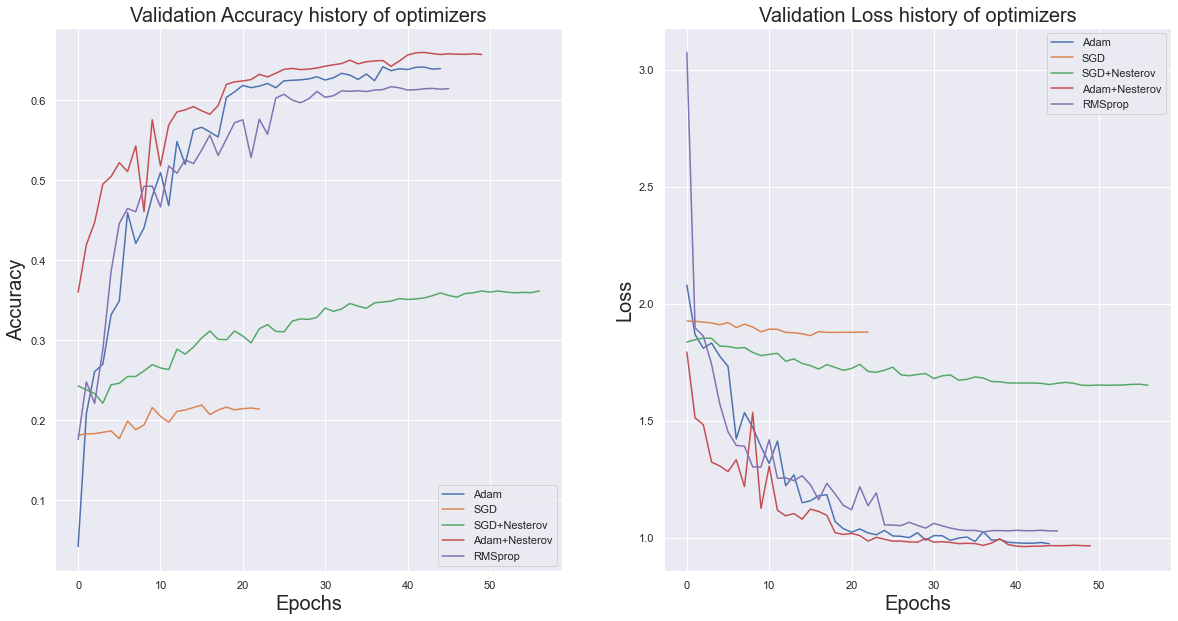

In [134]:
# Plot validation history of the tuned models using different optiizers
# Define number of subplots and size
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

# Plot Accuracy of model with different optimizers on validation set
ax[0].plot(CNN_Adam_history.history['val_accuracy'])
ax[0].plot(CNN_SGD_history.history['val_accuracy'])
ax[0].plot(CNN_NSGD_history.history['val_accuracy'])
ax[0].plot(CNN_Nadam_history.history['val_accuracy'])
ax[0].plot(CNN_RMSprop_history.history['val_accuracy'])
ax[0].set_title('Validation Accuracy history of optimizers', fontsize = 20)
ax[0].set_ylabel('Accuracy', fontsize = 20)
ax[0].set_xlabel('Epochs', fontsize = 20)
ax[0].legend(['Adam', 'SGD', 'SGD+Nesterov', 'Adam+Nesterov', 'RMSprop'], loc='best')


# Plot Loss of model with different optimizers on validation set
ax[1].plot(CNN_Adam_history.history['val_loss'])
ax[1].plot(CNN_SGD_history.history['val_loss'])
ax[1].plot(CNN_NSGD_history.history['val_loss'])
ax[1].plot(CNN_Nadam_history.history['val_loss'])
ax[1].plot(CNN_RMSprop_history.history['val_loss'])
ax[1].set_title('Validation Loss history of optimizers', fontsize = 20)
ax[1].set_ylabel('Loss', fontsize = 20)
ax[1].set_xlabel('Epochs', fontsize = 20)
ax[1].legend(['Adam', 'SGD', 'SGD+Nesterov', 'Adam+Nesterov', 'RMSprop'], loc='best')



In terms of validation accuracy, SGD and SGD+Nesterov performed the worst even though SGD+Nesterov trained for the longest epochs. This is because SGD is a weaker algorithm compared to the other algorithms for our problem. RMSprop ranked third, just a little bit weaker than Adam, it hit a plateau later than Adam at around 25 epochs. Adam ranked second, but 4th in terms of training epochs, because it stopped improving faster than the other 3. Adam+Nesterov or Nadam is the best algorithm among them all, it trained for the second longest epochs only losing to SGD+Nesterov and it achieved the highest accuracy at rounded off, 65% accuracy. Note that the training looks quite volatile compared to before because we have used a smaller batch_size, resulting in more weight updates hence more fluctuations. 

In [141]:
# Load the saved tuned models

CNN_Adam = keras.models.load_model('./Tuned_models/CNN_Adam.h5')
CNN_SGD = keras.models.load_model('./Tuned_models/CNN_SGD.h5')
CNN_NSGD = keras.models.load_model('./Tuned_models/CNN_NSGD.h5')
CNN_Nadam = keras.models.load_model('./Tuned_models/CNN_Nadam.h5')
CNN_RMSprop = keras.models.load_model('./Tuned_models/CNN_RMSprop.h5')

In [142]:
# Display tuned models' performance on test_set
Adam_performance = CNN_Adam.evaluate(test_set, verbose=0)
SGD_performance = CNN_SGD.evaluate(test_set, verbose=0)
NSGD_performance = CNN_NSGD.evaluate(test_set, verbose=0)
Nadam_performance = CNN_Nadam.evaluate(test_set, verbose=0)
RMSprop_performance = CNN_RMSprop.evaluate(test_set, verbose=0)
overall_metrics = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC']
overall_performance = pd.DataFrame({'Metrics':overall_metrics, 'Adam':Adam_performance , 'SGD':SGD_performance , 'NSGD':NSGD_performance , 'Nadam':Nadam_performance , 'RMSprop':RMSprop_performance })

overall_performance

Metrics      Adam       SGD      NSGD     Nadam   RMSprop
0       Loss  1.002022  1.646398  1.646398  0.970159  1.035179
1   Accuracy  0.631931  0.358317  0.358317  0.648509  0.615770
2  Precision  0.720873  0.541381  0.541381  0.723272  0.745008
3     Recall  0.533575  0.143076  0.143076  0.565478  0.472973
4        AUC  0.917317  0.749620  0.749620  0.923660  0.910009

This table confirms that the best performing model is Nadam. It has the lowest loss among all models at 0.970159, highest accuracy at 65% accuracy. Highest recall  at 0.565478 and highest AUC at 0.923660. However, it is only the second highest in terms of precision, with RMSprop standing at first. Overall, it is quite obvious that Nadam prevails and will be selected as our final model. Therefore we will fully evaluate it next.

# Part E : Final Evaluation of our best model: CNN with Nadam

In [143]:
# Load the best model CNN_Nadam
final = keras.models.load_model('./Tuned_models/CNN_Nadam.h5')

**Plot the performance of CNN with Nadam**

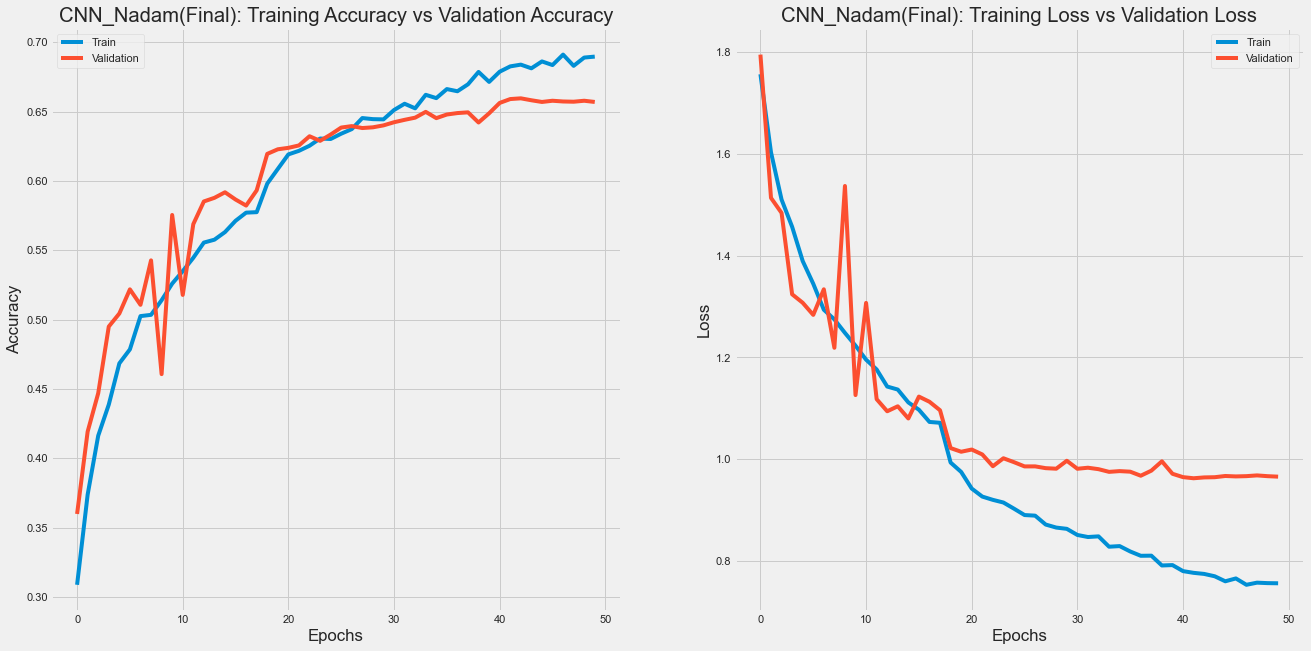

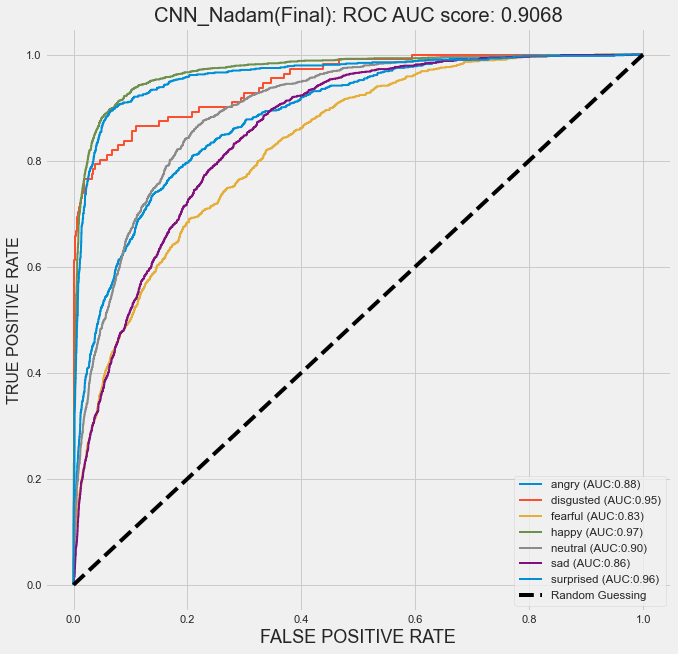

113/113 [==============================] - 3s 23ms/step


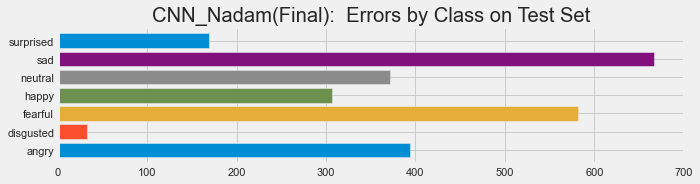

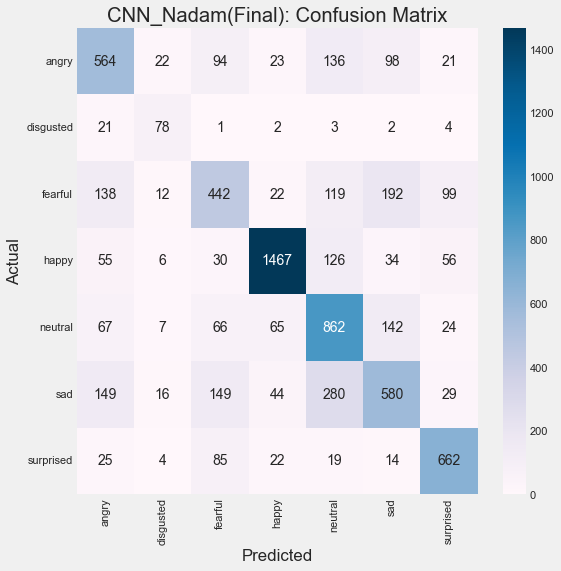

CNN_Nadam(Final): Classification Report on Test Set:
----------------------
               precision    recall  f1-score   support

       angry       0.55      0.59      0.57       958
   disgusted       0.54      0.70      0.61       111
     fearful       0.51      0.43      0.47      1024
       happy       0.89      0.83      0.86      1774
     neutral       0.56      0.70      0.62      1233
         sad       0.55      0.47      0.50      1247
   surprised       0.74      0.80      0.77       831

    accuracy                           0.65      7178
   macro avg       0.62      0.64      0.63      7178
weighted avg       0.65      0.65      0.65      7178



In [146]:
# Plot the performance of CNN with Nadam
plot_model_performance(final, CNN_Nadam_history, test_set, 'CNN_Nadam(Final)')

**Summary:** 
- Validation Accuracy and Loss hit a plateau at around 40 and 20 epochs respectively, more epochs will may help the model, or it may have gotten stuck at a local minimum.
- ROC AUC shows us that fearful and sad are the hardest class to separate and happy, surprised the easiest.
- Confusion matrix showed us that Sad images are often confused as Neutral, fearful or angry by the model.
- Classification report shows us most F1 score for disgusted, happy, neutral, and surprised are quite high. Whereas angry, fearful, sad are moderate. This proves that the model is not biased and can generalize well to classify all the classes with high enough precision and recall. 
- The accuracy of the model is also quite high, highest among all the models we have tried. Which is 65%, same as human's accuracy.

**Test our best model with 1 sample image from each and every class**

**1. Angry**

D:\Anaconda\envs\GPUenabled\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Predicted Class:  angry
Probability:  tf.Tensor(
[[0.6197522  0.12829117 0.15308052 0.00591208 0.02084496 0.05337257
  0.01874644]], shape=(1, 7), dtype=float32)


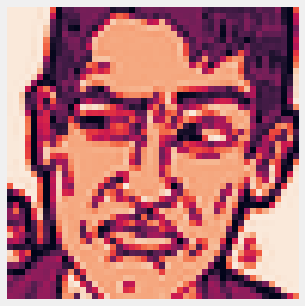

In [184]:
# Test ResNet on a sample image
classify_test(final, 'angry')

Correct

**2. Disgusted**

Predicted Class:  disgusted
Probability:  tf.Tensor(
[[2.0562665e-04 9.9936992e-01 1.6098822e-04 3.0717285e-05 5.7193542e-05
  1.0749449e-04 6.8048030e-05]], shape=(1, 7), dtype=float32)


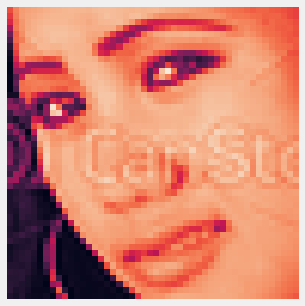

In [185]:
# Test ResNet on a sample image
classify_test(final, 'disgusted')

Correct

**3. Fearful**

Predicted Class:  fearful
Probability:  tf.Tensor(
[[0.35274273 0.02390874 0.41360486 0.00126318 0.01587708 0.07702783
  0.11557551]], shape=(1, 7), dtype=float32)


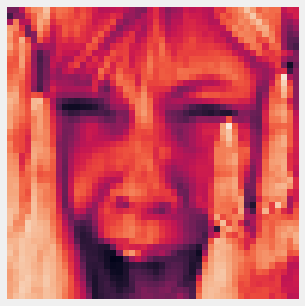

In [186]:
# Test ResNet on a sample image
classify_test(final, 'fearful')

Correct

**4. Happy**

Predicted Class:  happy
Probability:  tf.Tensor(
[[0.00325838 0.00361949 0.00413447 0.95887154 0.02053017 0.00159531
  0.00799072]], shape=(1, 7), dtype=float32)


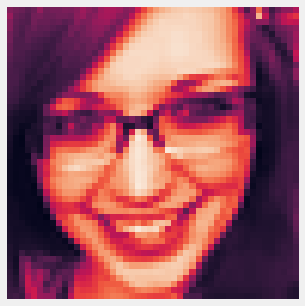

In [187]:
# Test ResNet on a sample image
classify_test(final, 'happy')

Correct

**5. Neutral**

Predicted Class:  neutral
Probability:  tf.Tensor(
[[5.9817497e-02 4.9741467e-04 1.6783875e-01 2.1130867e-02 6.2667876e-01
  1.1998515e-01 4.0516211e-03]], shape=(1, 7), dtype=float32)


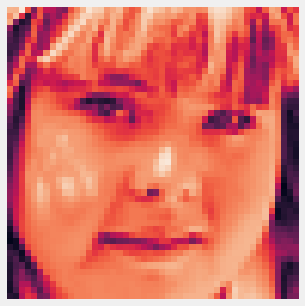

In [188]:
# Test ResNet on a sample image
classify_test(final, 'neutral')

Correct

**6. Sad**

Predicted Class:  angry
Probability:  tf.Tensor(
[[7.2560024e-01 2.2171521e-04 3.1615570e-02 1.5815845e-04 9.3419701e-02
  1.4742489e-01 1.5596667e-03]], shape=(1, 7), dtype=float32)


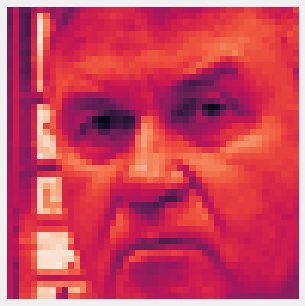

In [189]:
# Test ResNet on a sample image
classify_test(final, 'sad')

Wrong

**7. Surprised**

In [190]:
# Test ResNet on a sample image
classify_test(final, 'surprised')

Predicted Class:  surprised
Probability:  tf.Tensor(
[[5.2391324e-04 5.0225110e-05 3.1685498e-01 1.9299901e-03 5.6009134e-04
  1.1691700e-03 6.7891163e-01]], shape=(1, 7), dtype=float32)


Correct

**Results:** From the 7 outputs above, we can clearly see that the model only predicted one class wrong out of all 7 classes. The wrong prediction was angry when the picture was actually sad. However, if we analyze the picture with our human eyes, we can confirm that it does look a lot like he is angry. Therefore we cannot blame the model itself, but we can blame the dataset we have used.

As a conclusion, We are quite satisfied with the results of our final model as it has achieved human level intelligence at predicting human emotions based on facial expressions. 

**============================================== END OF PROJECT =======================================================**